In [1]:
from Utils import utils, plot
from Utils.train_batched_A2C import *
from Utils.A2C_inspection import *
from Utils.inspection_plots import *
import AC_modules.Networks as net
from AC_modules.BatchedA2C import MoveToBeaconSpatialA2C

import torch
import numpy as np
import matplotlib.pyplot as plt

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


# Load training session to inspect

In [2]:
load_dir = "Results/MoveToBeacon/"
queries = ['WUAY.npy']
train_dict = utils.load_session(load_dir, queries)

Number of matching filenames: 1
 ['S_A2C_conv-net_lr-7e-4_20-steps_32x32_120k-env-steps_240-unroll-len_WUAY.npy']


In [3]:
game_params = train_dict['game_params']
HPs = train_dict['HPs']
score = train_dict['score']
losses = train_dict['losses']
keywords = train_dict['keywords']
ID = keywords[-1]
print("HPs: ", HPs)

HPs:  {'action_space': 3, 'gamma': 0.99, 'n_steps': 20, 'H': 0.001, 'spatial_model': <class 'AC_modules.Networks.FullyConvSpatial'>, 'nonspatial_model': <class 'AC_modules.Networks.FullyConvNonSpatial'>, 'n_features': 256, 'n_channels': 32, 'spatial_dict': {'in_channels': 2}, 'nonspatial_dict': {'resolution': 32}, 'device': 'cuda'}


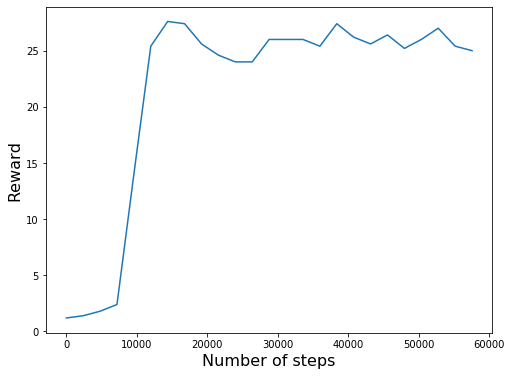

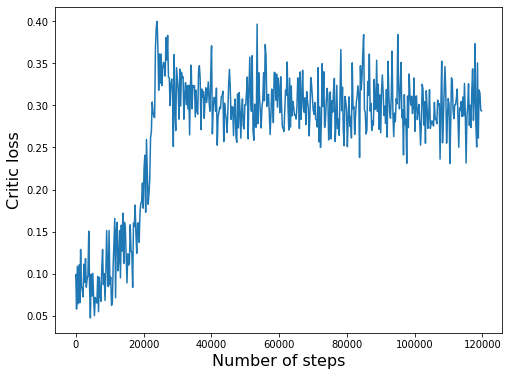

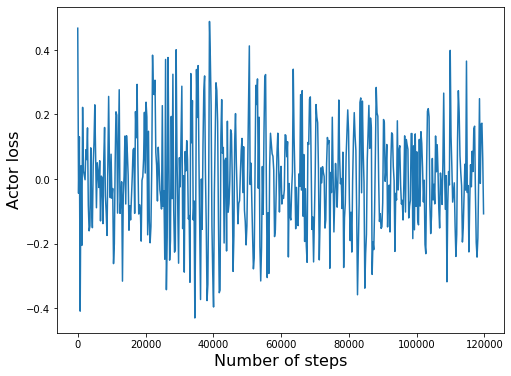

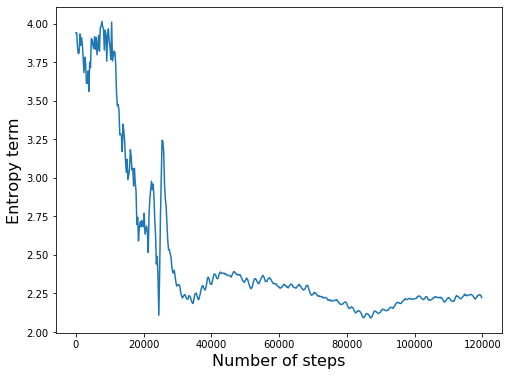

In [5]:
plot.plot_bA2C_session(score, losses, unroll_length=240, test_interval=10, moving_average=False, average_window=10)

# Update variables visualization 

First of all search for the step nearest to the point that we want to inspect

In [2]:
n = 25
step_idx =  0 + n*4800
step_idx

120000

In [3]:
load_dir = "Results/MoveToBeacon/Inspection/"
PID = "WUAY"
step_idx = step_idx
insp_dict = np.load(load_dir+PID+"_"+str(step_idx)+".npy", allow_pickle=True).item()

In [8]:
insp_dict.keys()

dict_keys(['state_traj', 'rewards', 'action_distr', 'action_sel', 'queue_distr', 'queue_sel', 'selectall_distr', 'selectall_sel', 'spatial_distr', 'spatial_sel', 'values', 'trg_values', 'critic_losses', 'advantages', 'actor_losses'])

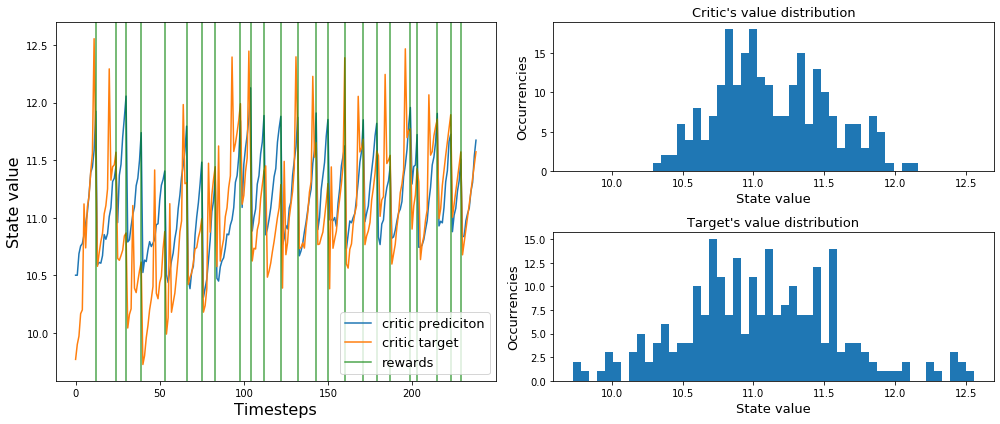

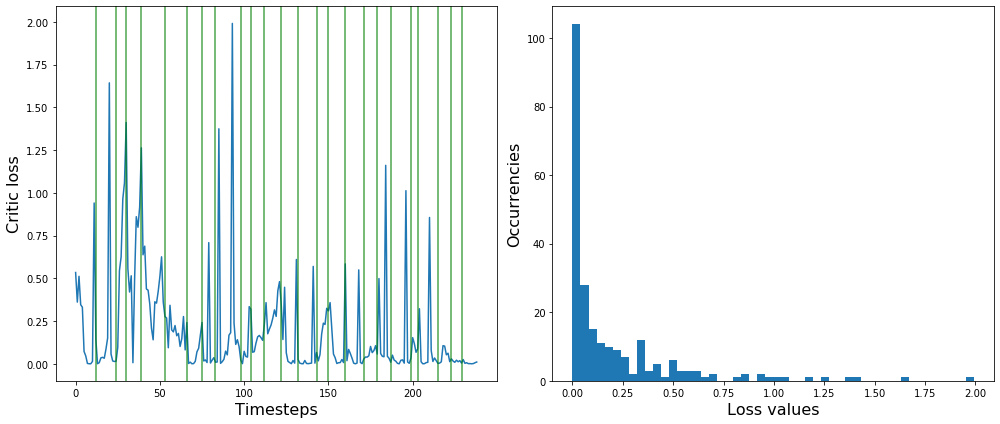

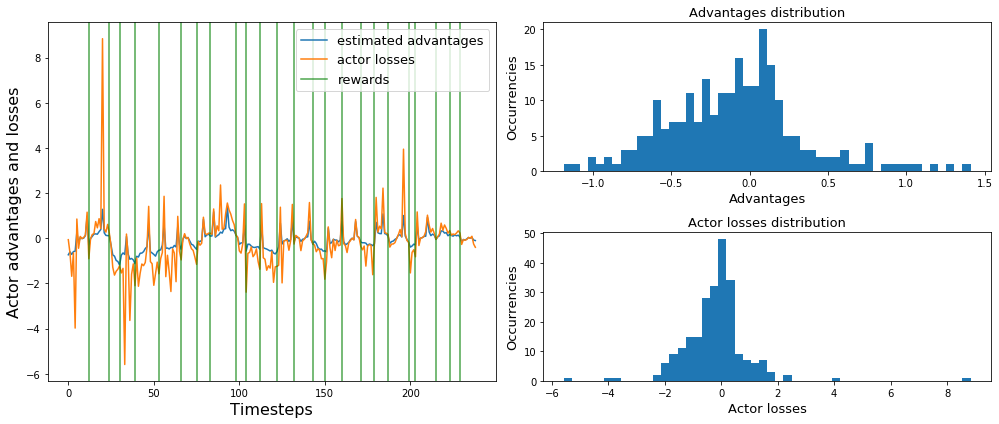

In [9]:
plot_update_curves(insp_dict)

In [23]:
#plot_update_curves(insp_dict, 55, 90)

# Frame by frame visualization

Coordinates:
1. Map works with y and then x
2. Actions work with x and then y


Step 0
_NO_OP: 	0.21
_SELECT_ARMY:  99.79 - _SELECT_ALL: 7.99
_MOVE_SCREEN:   0.00 - _NOT_QUEUED: 99.97 - POINT: (x,y)=(0,0)
Action selected:  [1]
State value: 10.5016
Move advantage: -0.7307


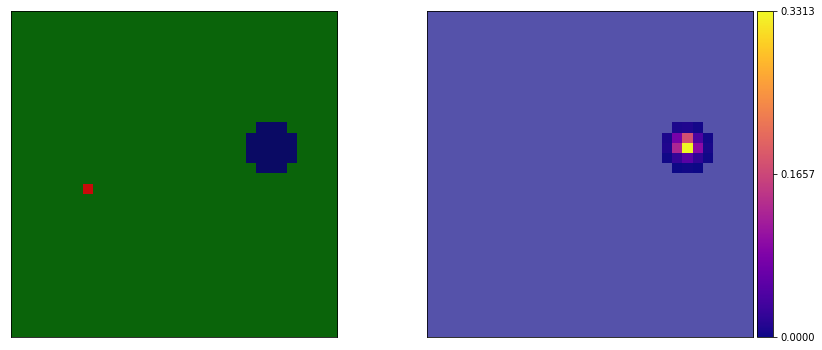


Step 1
_NO_OP: 	0.00
_SELECT_ARMY:  0.12 - _SELECT_ALL: 7.99
_MOVE_SCREEN:   99.88 - _NOT_QUEUED: 99.97 - POINT: (x,y)=(25,13)
Action selected:  [2]
State value: 10.5016
Move advantage: -0.6007


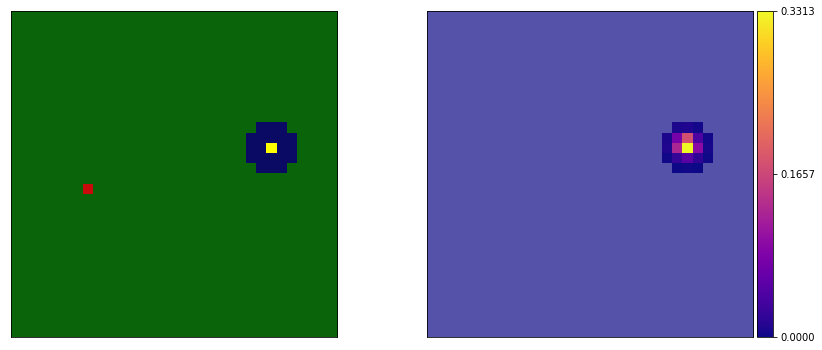


Step 2
_NO_OP: 	0.00
_SELECT_ARMY:  0.10 - _SELECT_ALL: 7.66
_MOVE_SCREEN:   99.90 - _NOT_QUEUED: 99.97 - POINT: (x,y)=(26,13)
Action selected:  [2]
State value: 10.6881
Move advantage: -0.7153


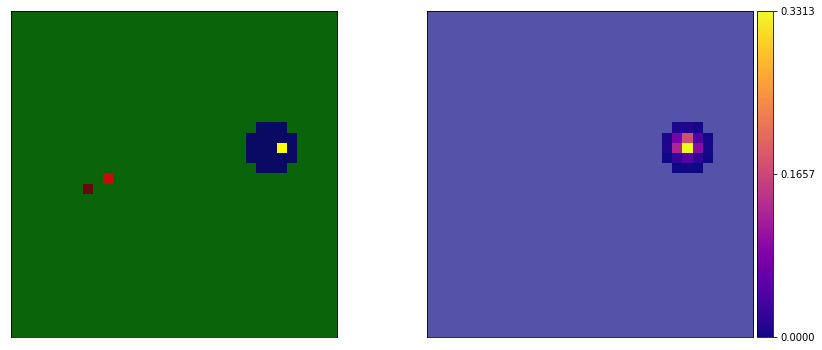


Step 3
_NO_OP: 	0.00
_SELECT_ARMY:  0.10 - _SELECT_ALL: 7.54
_MOVE_SCREEN:   99.90 - _NOT_QUEUED: 99.98 - POINT: (x,y)=(25,13)
Action selected:  [2]
State value: 10.7556
Move advantage: -0.5880


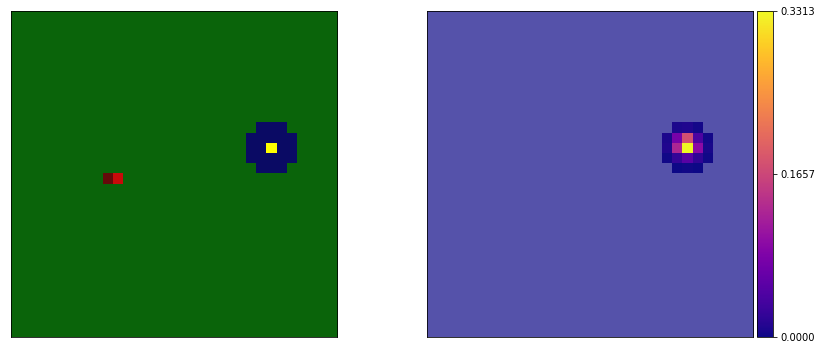


Step 4
_NO_OP: 	0.00
_SELECT_ARMY:  0.10 - _SELECT_ALL: 7.51
_MOVE_SCREEN:   99.90 - _NOT_QUEUED: 99.98 - POINT: (x,y)=(26,15)
Action selected:  [2]
State value: 10.7758
Move advantage: -0.5751


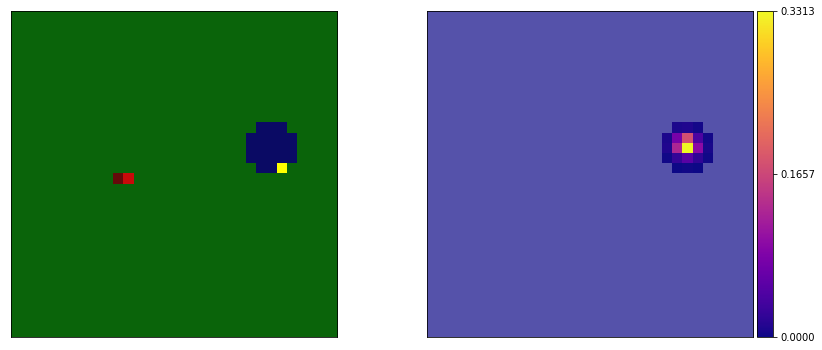


Step 5
_NO_OP: 	0.00
_SELECT_ARMY:  0.09 - _SELECT_ALL: 7.37
_MOVE_SCREEN:   99.91 - _NOT_QUEUED: 99.98 - POINT: (x,y)=(26,12)
Action selected:  [2]
State value: 10.8522
Move advantage: 0.2683


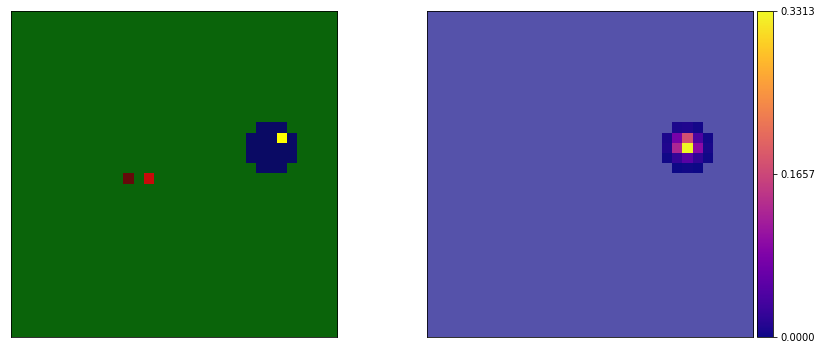


Step 6
_NO_OP: 	0.00
_SELECT_ARMY:  0.09 - _SELECT_ALL: 7.19
_MOVE_SCREEN:   99.91 - _NOT_QUEUED: 99.98 - POINT: (x,y)=(24,13)
Action selected:  [2]
State value: 10.9537
Move advantage: -0.2150


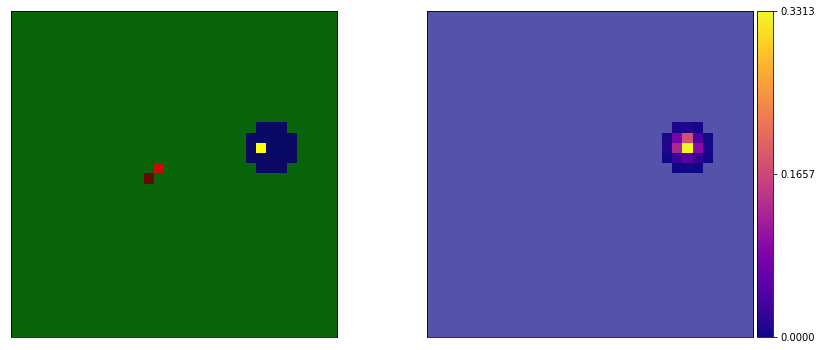


Step 7
_NO_OP: 	0.00
_SELECT_ARMY:  0.08 - _SELECT_ALL: 7.04
_MOVE_SCREEN:   99.92 - _NOT_QUEUED: 99.98 - POINT: (x,y)=(25,12)
Action selected:  [2]
State value: 11.0471
Move advantage: 0.0458


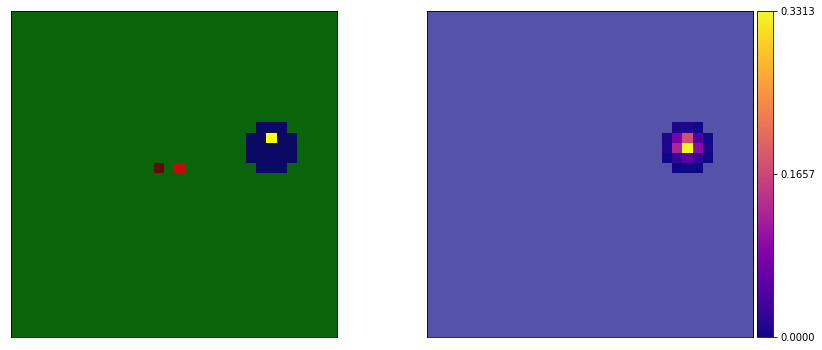


Step 8
_NO_OP: 	0.00
_SELECT_ARMY:  0.08 - _SELECT_ALL: 6.79
_MOVE_SCREEN:   99.92 - _NOT_QUEUED: 99.98 - POINT: (x,y)=(25,13)
Action selected:  [2]
State value: 11.2035
Move advantage: -0.0149


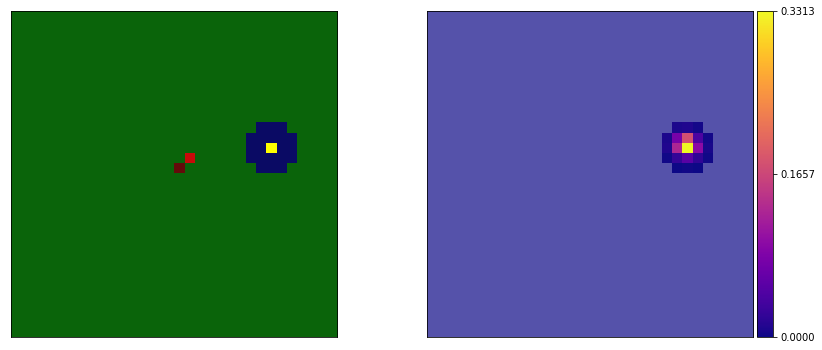


Step 9
_NO_OP: 	0.00
_SELECT_ARMY:  0.07 - _SELECT_ALL: 6.51
_MOVE_SCREEN:   99.93 - _NOT_QUEUED: 99.98 - POINT: (x,y)=(26,14)
Action selected:  [2]
State value: 11.3923
Move advantage: 0.0087


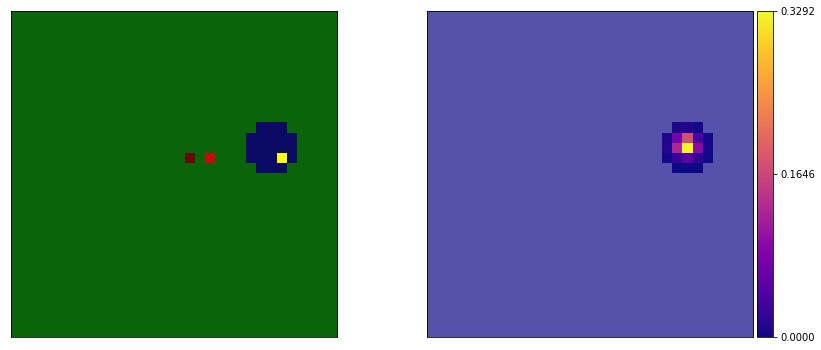


Step 10
_NO_OP: 	0.00
_SELECT_ARMY:  0.07 - _SELECT_ALL: 6.44
_MOVE_SCREEN:   99.93 - _NOT_QUEUED: 99.99 - POINT: (x,y)=(25,13)
Action selected:  [2]
State value: 11.4408
Move advantage: 0.1183


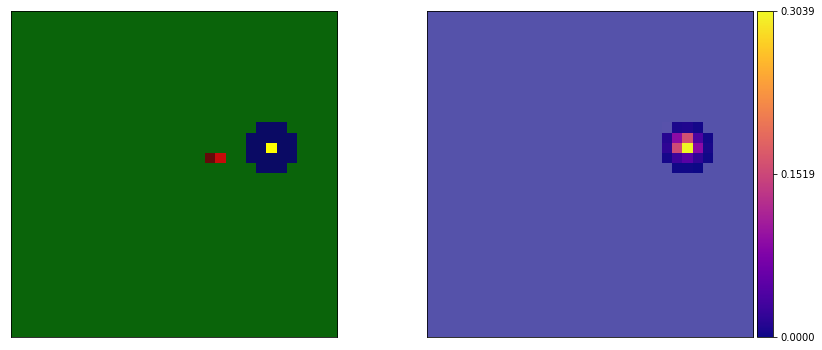


Step 11
_NO_OP: 	0.00
_SELECT_ARMY:  0.06 - _SELECT_ALL: 6.24
_MOVE_SCREEN:   99.94 - _NOT_QUEUED: 99.99 - POINT: (x,y)=(25,13)
Action selected:  [2]
State value: 11.5847
Move advantage: 0.9699


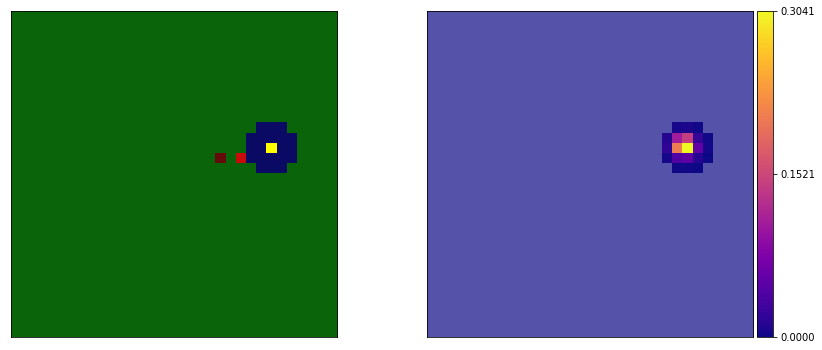


Step 12
_NO_OP: 	0.00
_SELECT_ARMY:  0.05 - _SELECT_ALL: 5.77
_MOVE_SCREEN:   99.95 - _NOT_QUEUED: 99.99 - POINT: (x,y)=(24,12)
Action selected:  [2]
State value: 11.9252
Move advantage: -0.3789


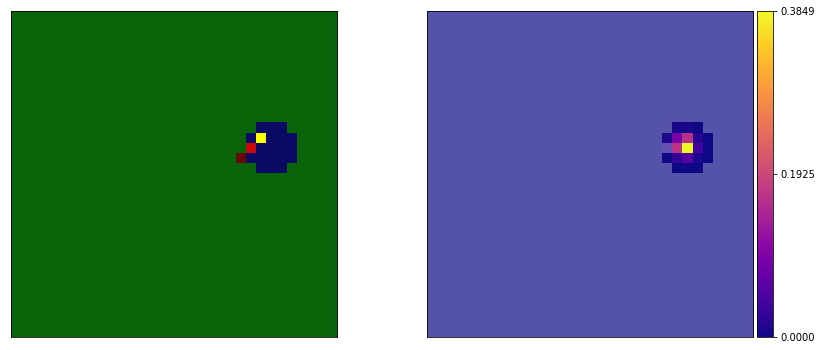


Step 13
_NO_OP: 	0.00
_SELECT_ARMY:  0.12 - _SELECT_ALL: 7.82
_MOVE_SCREEN:   99.88 - _NOT_QUEUED: 99.97 - POINT: (x,y)=(5,5)
Action selected:  [2]
State value: 10.5912
Move advantage: -0.0122


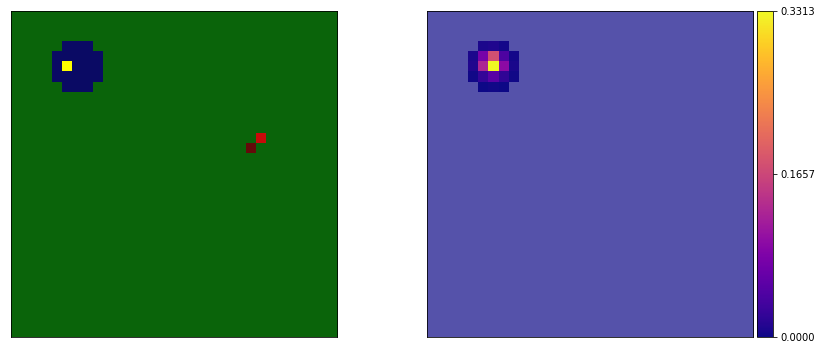


Step 14
_NO_OP: 	0.00
_SELECT_ARMY:  0.11 - _SELECT_ALL: 7.78
_MOVE_SCREEN:   99.89 - _NOT_QUEUED: 99.97 - POINT: (x,y)=(5,5)
Action selected:  [2]
State value: 10.6125
Move advantage: 0.0810


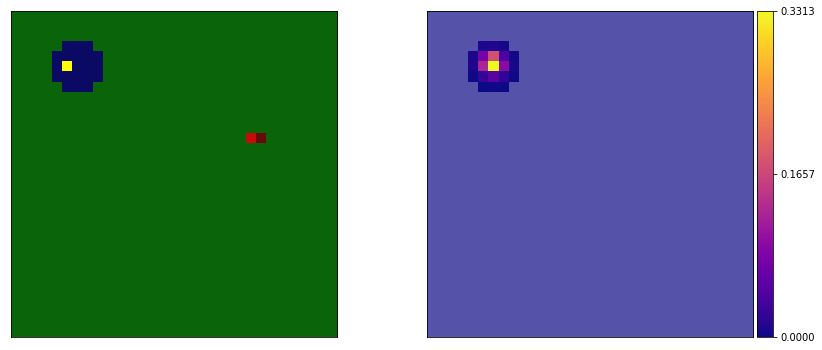


Step 15
_NO_OP: 	0.00
_SELECT_ARMY:  0.11 - _SELECT_ALL: 7.80
_MOVE_SCREEN:   99.89 - _NOT_QUEUED: 99.97 - POINT: (x,y)=(6,5)
Action selected:  [2]
State value: 10.6060
Move advantage: 0.1867


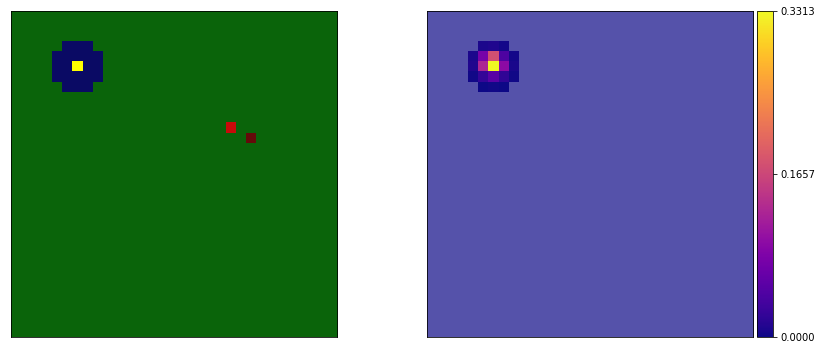


Step 16
_NO_OP: 	0.00
_SELECT_ARMY:  0.11 - _SELECT_ALL: 7.68
_MOVE_SCREEN:   99.89 - _NOT_QUEUED: 99.97 - POINT: (x,y)=(5,6)
Action selected:  [2]
State value: 10.6711
Move advantage: 0.1942


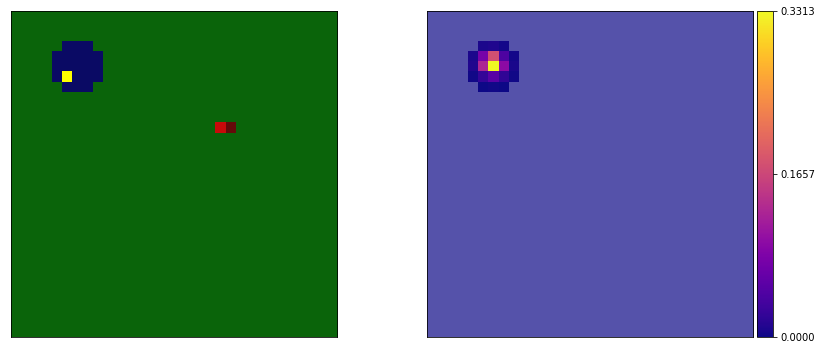


Step 17
_NO_OP: 	0.00
_SELECT_ARMY:  0.10 - _SELECT_ALL: 7.37
_MOVE_SCREEN:   99.90 - _NOT_QUEUED: 99.98 - POINT: (x,y)=(5,4)
Action selected:  [2]
State value: 10.8542
Move advantage: 0.1803


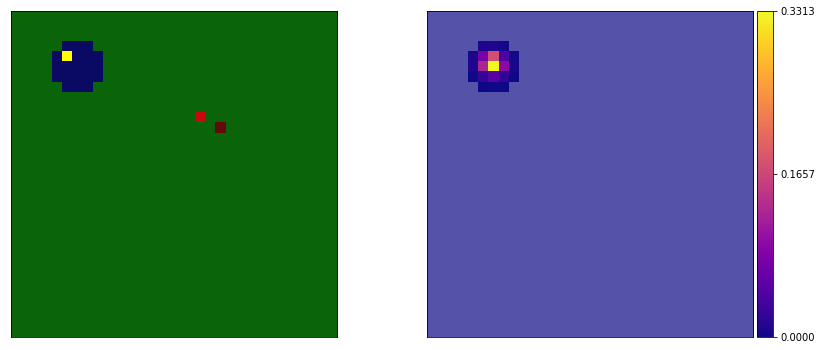


Step 18
_NO_OP: 	0.00
_SELECT_ARMY:  0.10 - _SELECT_ALL: 7.45
_MOVE_SCREEN:   99.90 - _NOT_QUEUED: 99.98 - POINT: (x,y)=(6,6)
Action selected:  [2]
State value: 10.8137
Move advantage: 0.2926


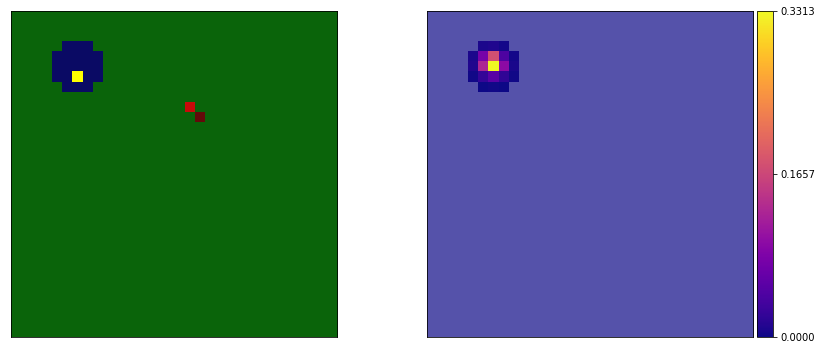


Step 19
_NO_OP: 	0.00
_SELECT_ARMY:  0.10 - _SELECT_ALL: 7.37
_MOVE_SCREEN:   99.90 - _NOT_QUEUED: 99.98 - POINT: (x,y)=(6,5)
Action selected:  [2]
State value: 10.8626
Move advantage: 0.3886


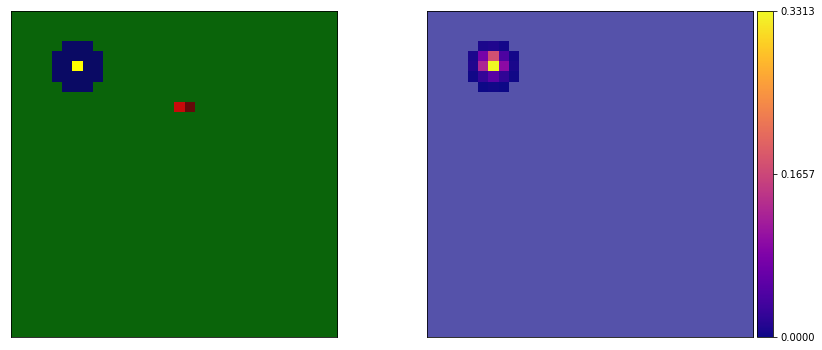


Step 20
_NO_OP: 	0.00
_SELECT_ARMY:  0.09 - _SELECT_ALL: 7.12
_MOVE_SCREEN:   99.91 - _NOT_QUEUED: 99.98 - POINT: (x,y)=(4,3)
Action selected:  [2]
State value: 11.0106
Move advantage: 1.2821


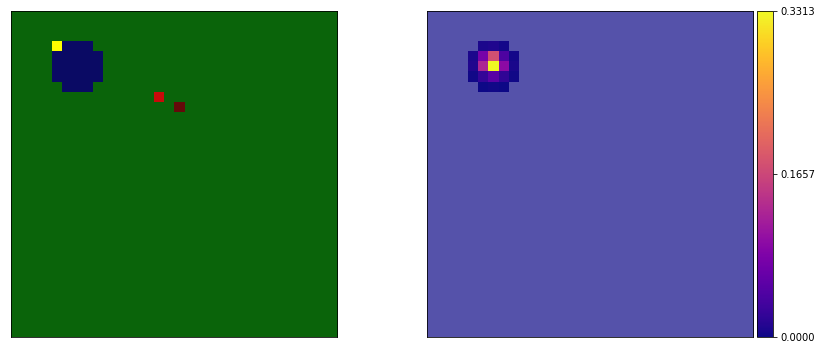


Step 21
_NO_OP: 	0.00
_SELECT_ARMY:  0.09 - _SELECT_ALL: 7.00
_MOVE_SCREEN:   99.91 - _NOT_QUEUED: 99.98 - POINT: (x,y)=(6,4)
Action selected:  [2]
State value: 11.0873
Move advantage: 0.2397


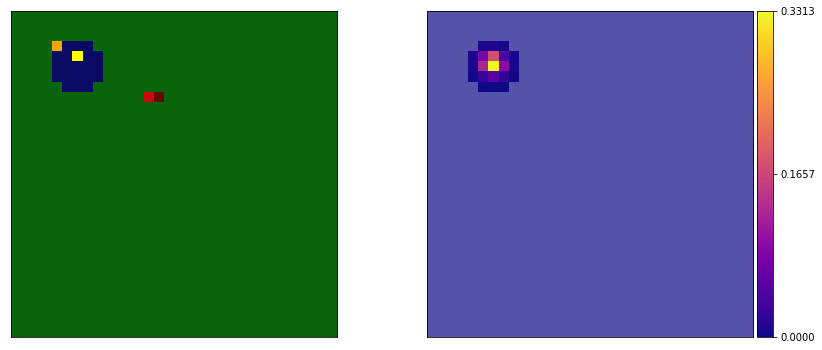


Step 22
_NO_OP: 	0.00
_SELECT_ARMY:  0.08 - _SELECT_ALL: 6.64
_MOVE_SCREEN:   99.92 - _NOT_QUEUED: 99.98 - POINT: (x,y)=(5,5)
Action selected:  [2]
State value: 11.3143
Move advantage: 0.1281


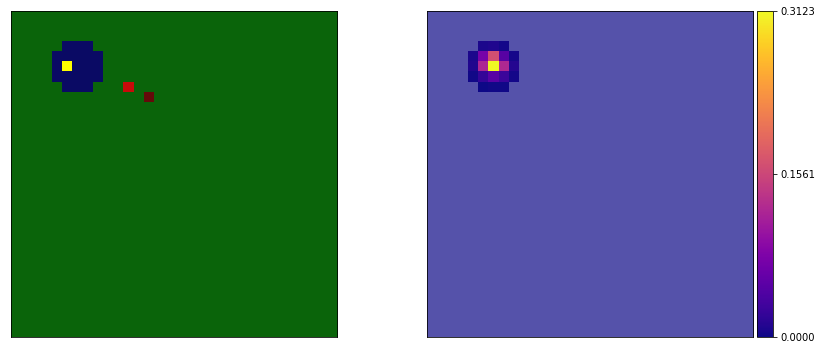


Step 23
_NO_OP: 	0.00
_SELECT_ARMY:  0.07 - _SELECT_ALL: 6.60
_MOVE_SCREEN:   99.93 - _NOT_QUEUED: 99.98 - POINT: (x,y)=(4,4)
Action selected:  [2]
State value: 11.3435
Move advantage: 0.1161


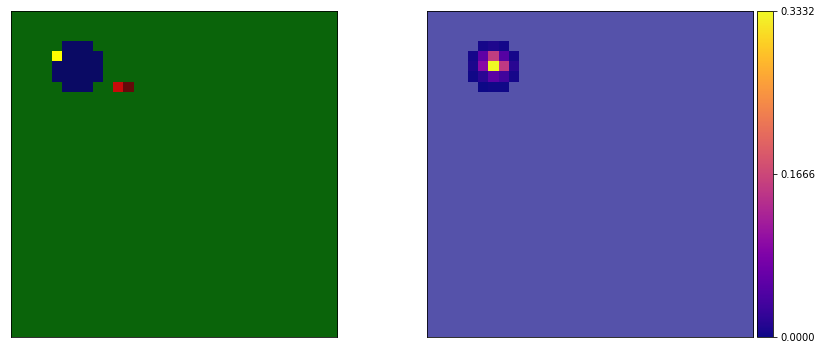


Step 24
_NO_OP: 	0.00
_SELECT_ARMY:  0.07 - _SELECT_ALL: 6.46
_MOVE_SCREEN:   99.93 - _NOT_QUEUED: 99.99 - POINT: (x,y)=(7,5)
Action selected:  [2]
State value: 11.4466
Move advantage: 0.1227


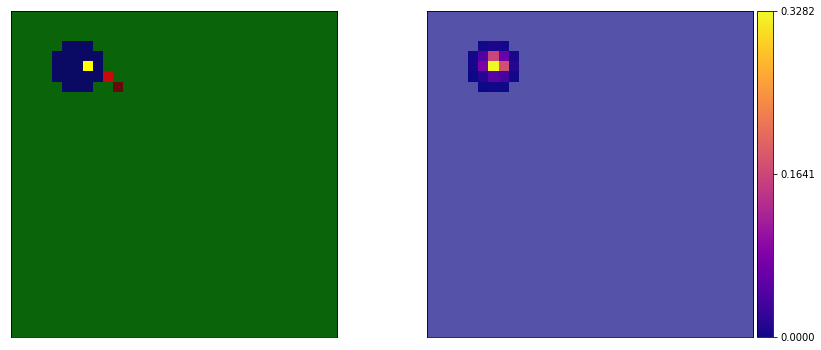


Step 25
_NO_OP: 	0.00
_SELECT_ARMY:  0.09 - _SELECT_ALL: 7.22
_MOVE_SCREEN:   99.91 - _NOT_QUEUED: 99.98 - POINT: (x,y)=(10,14)
Action selected:  [2]
State value: 10.9581
Move advantage: -0.3104


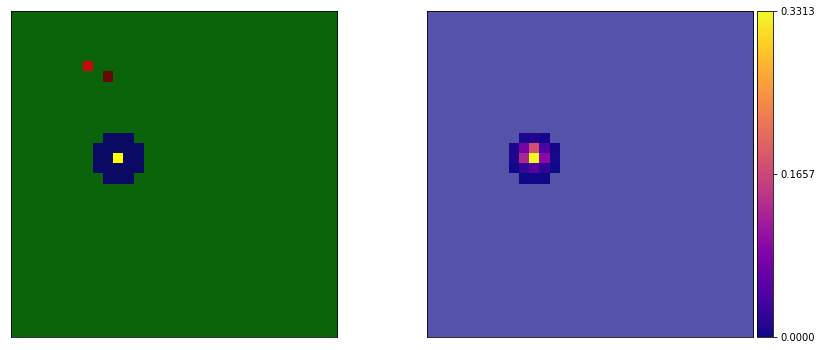


Step 26
_NO_OP: 	0.00
_SELECT_ARMY:  0.07 - _SELECT_ALL: 6.56
_MOVE_SCREEN:   99.93 - _NOT_QUEUED: 99.98 - POINT: (x,y)=(10,13)
Action selected:  [2]
State value: 11.3692
Move advantage: -0.7381


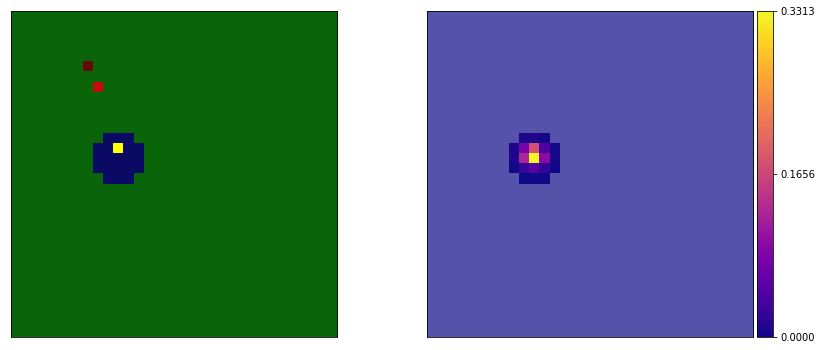


Step 27
_NO_OP: 	0.00
_SELECT_ARMY:  0.07 - _SELECT_ALL: 6.41
_MOVE_SCREEN:   99.93 - _NOT_QUEUED: 99.99 - POINT: (x,y)=(9,14)
Action selected:  [2]
State value: 11.4641
Move advantage: -0.7911


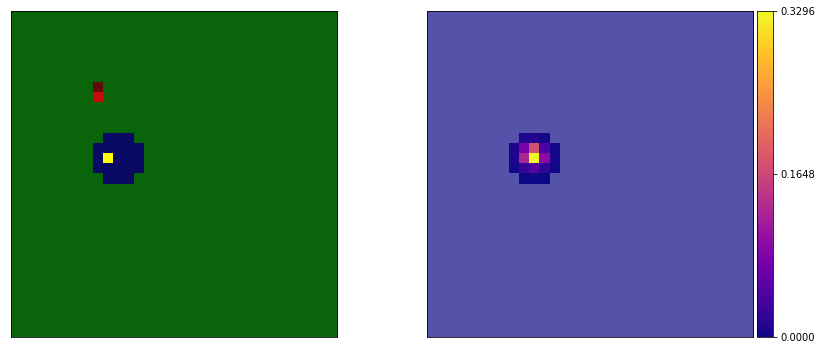


Step 28
_NO_OP: 	0.00
_SELECT_ARMY:  0.06 - _SELECT_ALL: 6.07
_MOVE_SCREEN:   99.94 - _NOT_QUEUED: 99.99 - POINT: (x,y)=(10,13)
Action selected:  [2]
State value: 11.7014
Move advantage: -0.9822


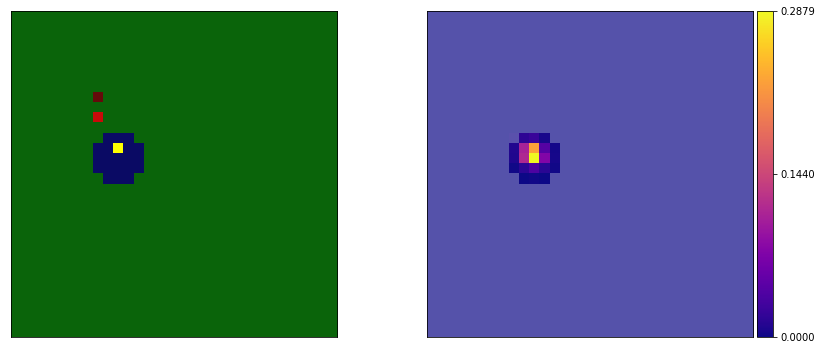


Step 29
_NO_OP: 	0.00
_SELECT_ARMY:  0.05 - _SELECT_ALL: 5.84
_MOVE_SCREEN:   99.95 - _NOT_QUEUED: 99.99 - POINT: (x,y)=(10,14)
Action selected:  [2]
State value: 11.8720
Move advantage: -1.0294


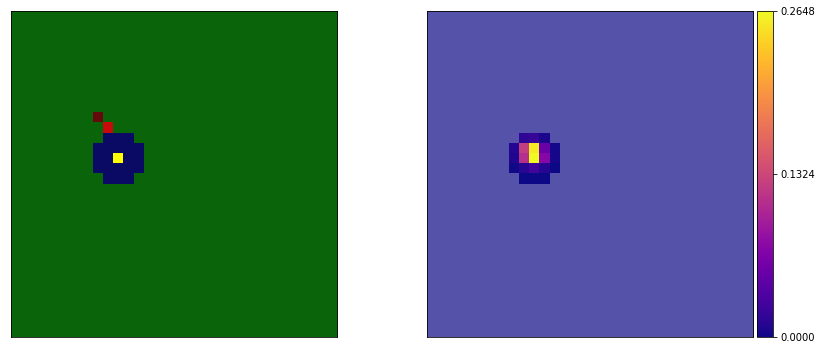


Step 30
_NO_OP: 	0.00
_SELECT_ARMY:  0.05 - _SELECT_ALL: 5.60
_MOVE_SCREEN:   99.95 - _NOT_QUEUED: 99.99 - POINT: (x,y)=(10,14)
Action selected:  [2]
State value: 12.0562
Move advantage: -1.1882


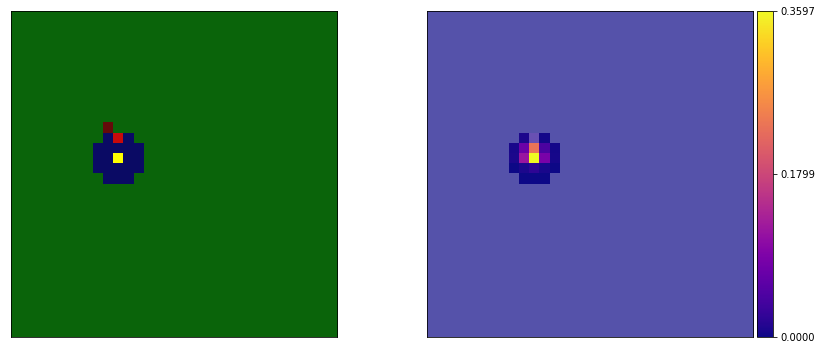


Step 31
_NO_OP: 	0.00
_SELECT_ARMY:  0.10 - _SELECT_ALL: 7.48
_MOVE_SCREEN:   99.90 - _NOT_QUEUED: 99.98 - POINT: (x,y)=(22,7)
Action selected:  [2]
State value: 10.7902
Move advantage: -0.7468


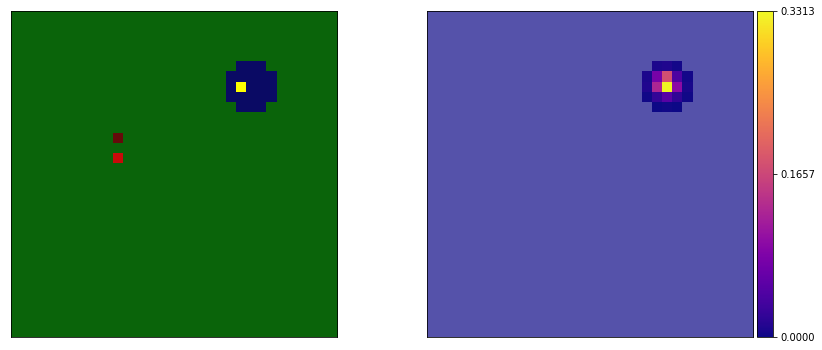


Step 32
_NO_OP: 	0.00
_SELECT_ARMY:  0.10 - _SELECT_ALL: 7.45
_MOVE_SCREEN:   99.90 - _NOT_QUEUED: 99.98 - POINT: (x,y)=(22,7)
Action selected:  [2]
State value: 10.8089
Move advantage: -0.6482


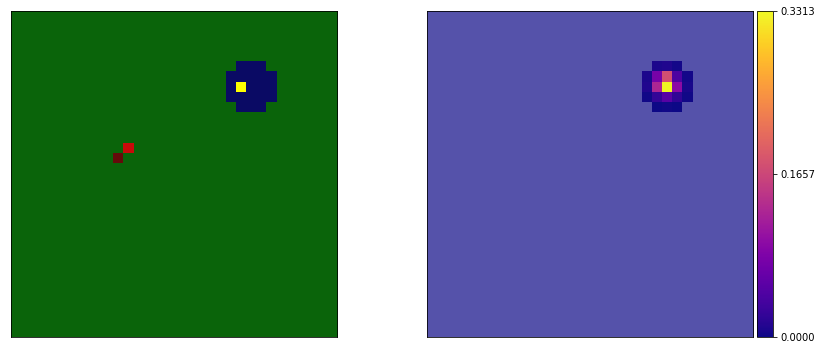


Step 33
_NO_OP: 	0.00
_SELECT_ARMY:  0.10 - _SELECT_ALL: 7.25
_MOVE_SCREEN:   99.90 - _NOT_QUEUED: 99.98 - POINT: (x,y)=(25,5)
Action selected:  [2]
State value: 10.9274
Move advantage: -0.7175


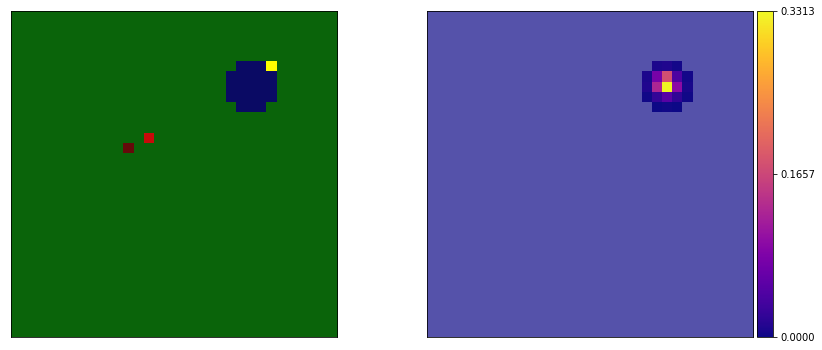


Step 34
_NO_OP: 	0.00
_SELECT_ARMY:  0.09 - _SELECT_ALL: 7.08
_MOVE_SCREEN:   99.91 - _NOT_QUEUED: 99.98 - POINT: (x,y)=(24,7)
Action selected:  [2]
State value: 11.0270
Move advantage: 0.0791


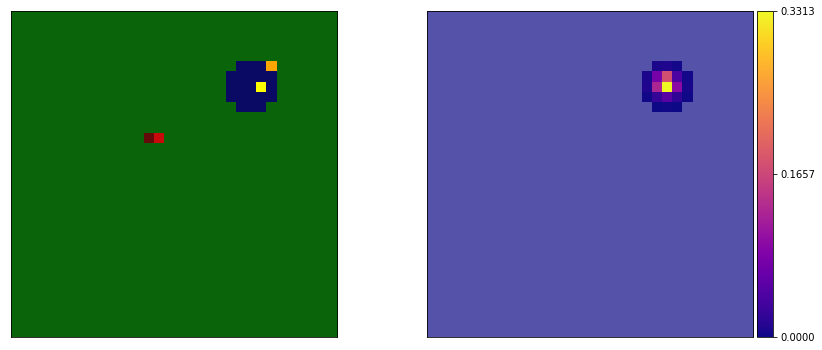


Step 35
_NO_OP: 	0.00
_SELECT_ARMY:  0.09 - _SELECT_ALL: 6.99
_MOVE_SCREEN:   99.91 - _NOT_QUEUED: 99.98 - POINT: (x,y)=(23,7)
Action selected:  [2]
State value: 11.0940
Move advantage: -0.7042


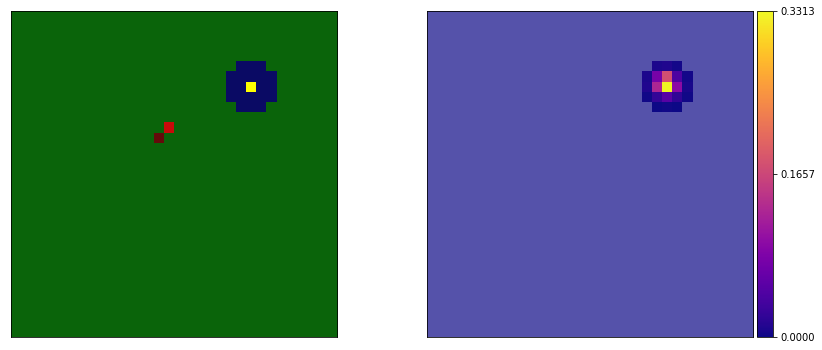


Step 36
_NO_OP: 	0.00
_SELECT_ARMY:  0.08 - _SELECT_ALL: 6.71
_MOVE_SCREEN:   99.92 - _NOT_QUEUED: 99.98 - POINT: (x,y)=(24,8)
Action selected:  [2]
State value: 11.2786
Move advantage: -0.9277


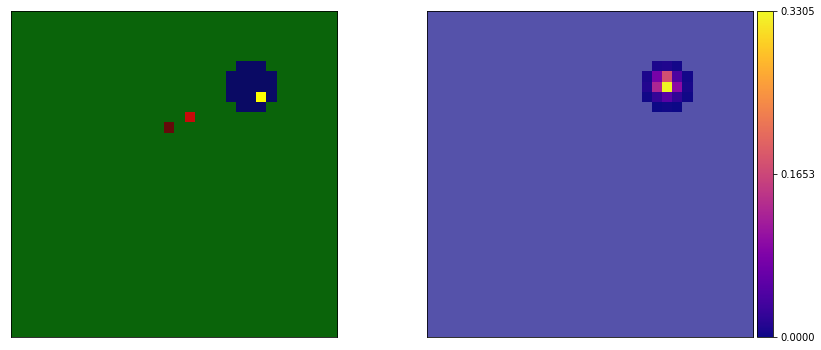


Step 37
_NO_OP: 	0.00
_SELECT_ARMY:  0.07 - _SELECT_ALL: 6.61
_MOVE_SCREEN:   99.93 - _NOT_QUEUED: 99.98 - POINT: (x,y)=(23,6)
Action selected:  [2]
State value: 11.3440
Move advantage: -0.8938


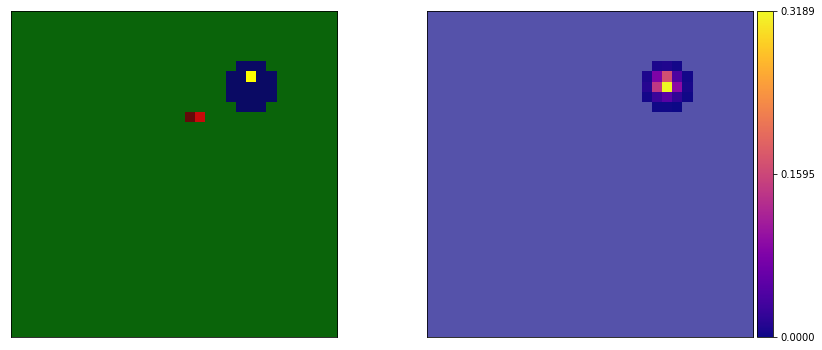


Step 38
_NO_OP: 	0.00
_SELECT_ARMY:  0.07 - _SELECT_ALL: 6.39
_MOVE_SCREEN:   99.93 - _NOT_QUEUED: 99.99 - POINT: (x,y)=(23,7)
Action selected:  [2]
State value: 11.4987
Move advantage: -0.9578


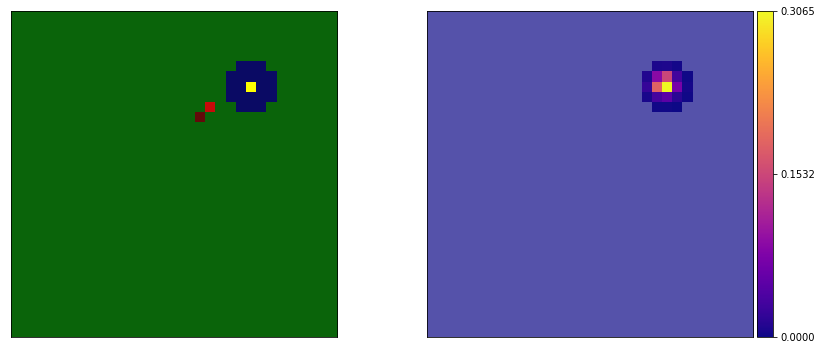


Step 39
_NO_OP: 	0.00
_SELECT_ARMY:  0.06 - _SELECT_ALL: 6.06
_MOVE_SCREEN:   99.94 - _NOT_QUEUED: 99.99 - POINT: (x,y)=(23,6)
Action selected:  [2]
State value: 11.7391
Move advantage: -1.1240


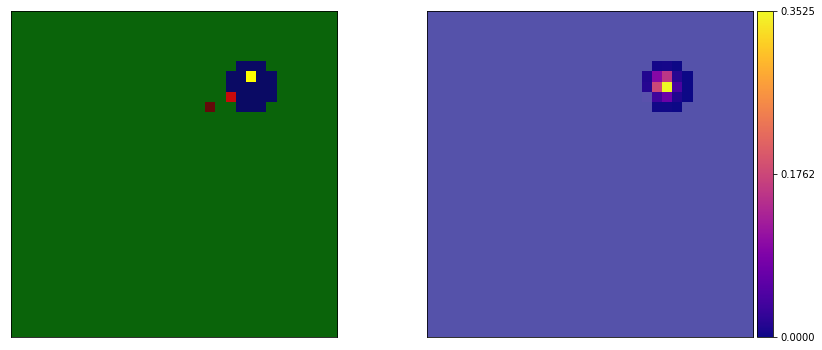


Step 40
_NO_OP: 	0.00
_SELECT_ARMY:  0.12 - _SELECT_ALL: 7.93
_MOVE_SCREEN:   99.88 - _NOT_QUEUED: 99.97 - POINT: (x,y)=(3,17)
Action selected:  [2]
State value: 10.5252
Move advantage: -0.7986


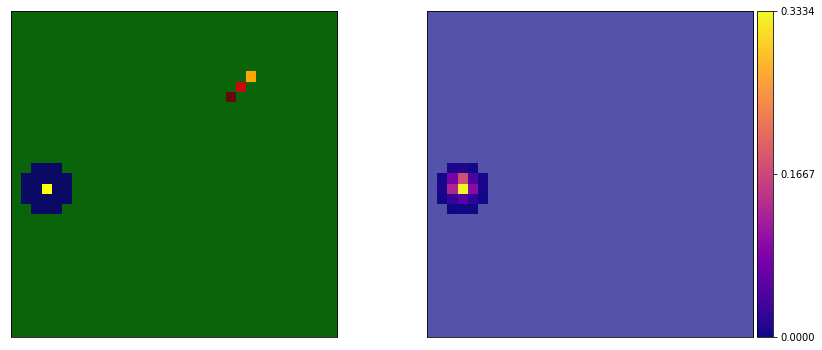


Step 41
_NO_OP: 	0.00
_SELECT_ARMY:  0.12 - _SELECT_ALL: 7.73
_MOVE_SCREEN:   99.88 - _NOT_QUEUED: 99.97 - POINT: (x,y)=(2,16)
Action selected:  [2]
State value: 10.6328
Move advantage: -0.8296


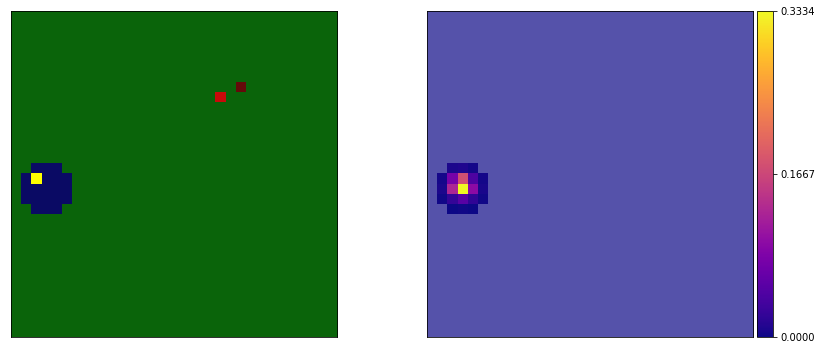


Step 42
_NO_OP: 	0.00
_SELECT_ARMY:  0.12 - _SELECT_ALL: 7.76
_MOVE_SCREEN:   99.88 - _NOT_QUEUED: 99.97 - POINT: (x,y)=(4,17)
Action selected:  [2]
State value: 10.6199
Move advantage: -0.6615


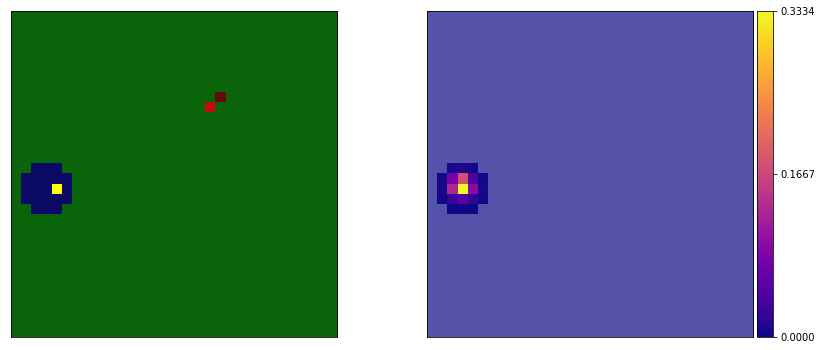


Step 43
_NO_OP: 	0.00
_SELECT_ARMY:  0.11 - _SELECT_ALL: 7.59
_MOVE_SCREEN:   99.89 - _NOT_QUEUED: 99.97 - POINT: (x,y)=(3,16)
Action selected:  [2]
State value: 10.7198
Move advantage: -0.6563


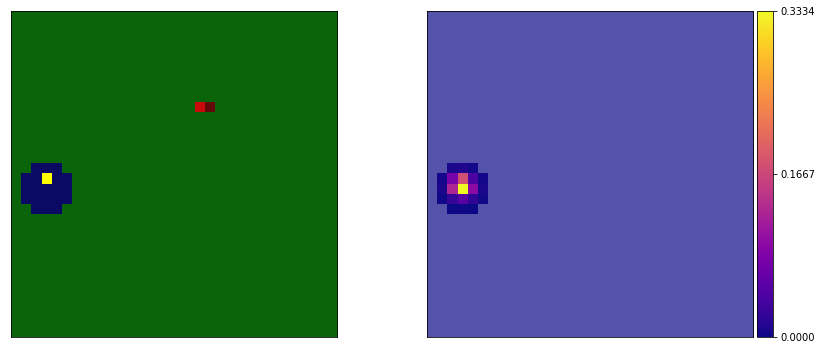


Step 44
_NO_OP: 	0.00
_SELECT_ARMY:  0.11 - _SELECT_ALL: 7.46
_MOVE_SCREEN:   99.89 - _NOT_QUEUED: 99.98 - POINT: (x,y)=(2,17)
Action selected:  [2]
State value: 10.7933
Move advantage: -0.5915


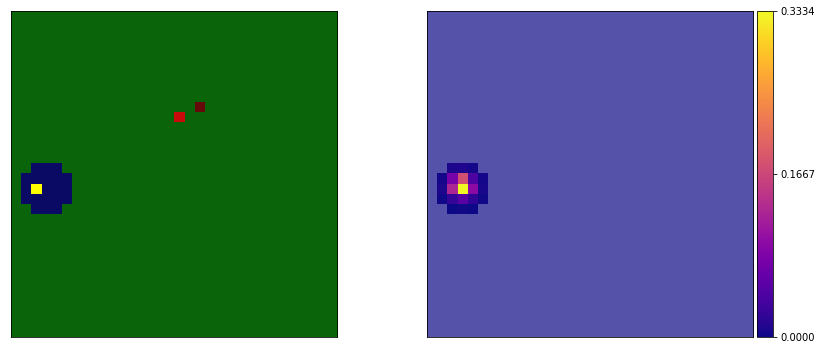


Step 45
_NO_OP: 	0.00
_SELECT_ARMY:  0.11 - _SELECT_ALL: 7.54
_MOVE_SCREEN:   99.89 - _NOT_QUEUED: 99.98 - POINT: (x,y)=(4,17)
Action selected:  [2]
State value: 10.7506
Move advantage: -0.4569


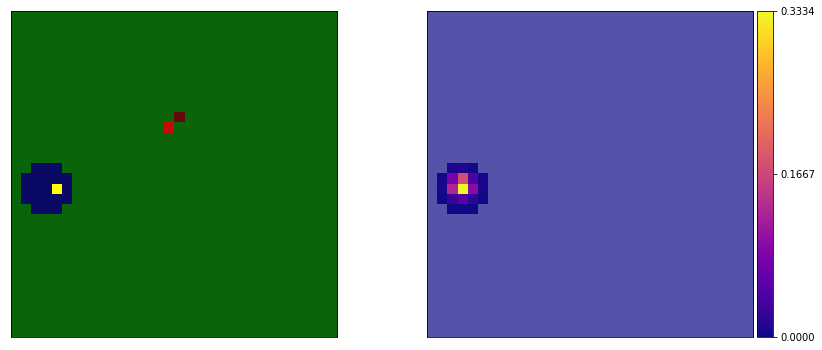


Step 46
_NO_OP: 	0.00
_SELECT_ARMY:  0.11 - _SELECT_ALL: 7.48
_MOVE_SCREEN:   99.89 - _NOT_QUEUED: 99.98 - POINT: (x,y)=(3,17)
Action selected:  [2]
State value: 10.7791
Move advantage: -0.3746


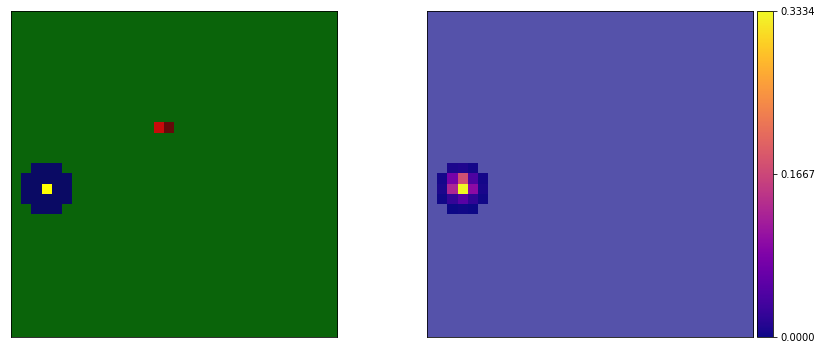


Step 47
_NO_OP: 	0.00
_SELECT_ARMY:  0.10 - _SELECT_ALL: 7.41
_MOVE_SCREEN:   99.90 - _NOT_QUEUED: 99.98 - POINT: (x,y)=(4,17)
Action selected:  [2]
State value: 10.8128
Move advantage: 0.6023


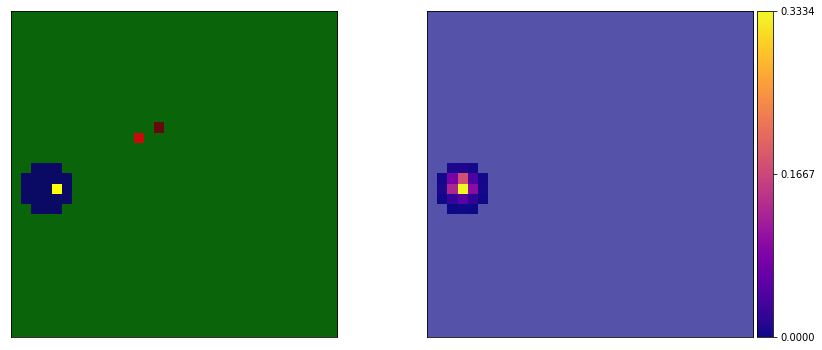


Step 48
_NO_OP: 	0.00
_SELECT_ARMY:  0.10 - _SELECT_ALL: 7.20
_MOVE_SCREEN:   99.90 - _NOT_QUEUED: 99.98 - POINT: (x,y)=(3,16)
Action selected:  [2]
State value: 10.9404
Move advantage: -0.5957


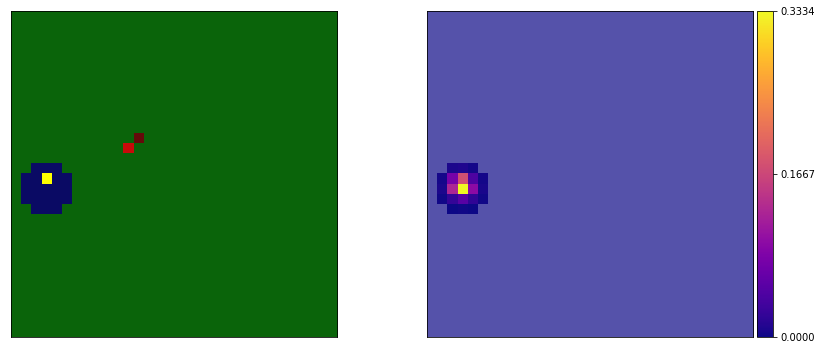


Step 49
_NO_OP: 	0.00
_SELECT_ARMY:  0.10 - _SELECT_ALL: 7.19
_MOVE_SCREEN:   99.90 - _NOT_QUEUED: 99.98 - POINT: (x,y)=(3,16)
Action selected:  [2]
State value: 10.9481
Move advantage: -0.6507


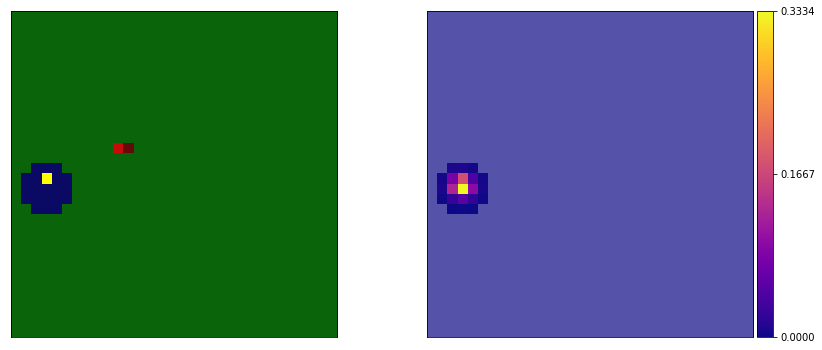

In [10]:
#for t in range(len(insp_dict['state_traj'])):
for t in range(50):
    print_action_info(insp_dict, t)
    plot_screen_and_decision(insp_dict, t)

# Value and policy evolution with training

In [11]:
load = True
if load:
    agent = torch.load("Results/MoveToBeacon/agent_"+PID, map_location='cpu')
    agent.device = 'cpu'
    agent1 = torch.load("Results/MoveToBeacon/agent_"+PID, map_location='cpu')
    agent1.device = 'cpu'
else: # For models not yet saved because they are still training
    RESOLUTION = 32
    MAX_STEPS = 256
    game_params = dict(feature_screen=RESOLUTION, feature_minimap=RESOLUTION, action_space="FEATURES") 
    env = init_game(game_params, max_steps=MAX_STEPS)
    model_number = 0
    model_names = {0:"FullyConvNet_v0", 1:"FullyConvNet_v1", 2:"FullyConvNet_V2", 3:"ControlNet", 4:"GatedRelationalNet"}

    if model_number == 0:
        print(model_names[model_number]+" selected.")
        spatial_model = net.FullyConvSpatial
        nonspatial_model = net.FullyConvNonSpatial
        n_channels = 32
        n_features = 256
        spatial_dict = {"in_channels":2}
        nonspatial_dict = {'resolution':RESOLUTION}

    elif model_number == 1:
        print(model_names[model_number]+" selected.")
        spatial_model = net.FullyConvSpatial_v1
        nonspatial_model = net.FullyConvNonSpatial_v1
        n_channels = 32
        n_features = 256
        spatial_dict = {"in_channels":3, 'resolution':RESOLUTION}
        nonspatial_dict = {'resolution':RESOLUTION}

    elif model_number == 2:
        print(model_names[model_number]+" selected.")
        spatial_model = net.FullyConvSpatial_v2
        nonspatial_model = net.FullyConvNonSpatial_v2
        n_channels = 32
        n_features = 256
        spatial_dict = {"in_channels":6, 'resolution':RESOLUTION}
        nonspatial_dict = {'resolution':RESOLUTION}

    elif model_number == 3:
        print(model_names[model_number]+" selected.")
        spatial_model = net.SpatialFeatures
        nonspatial_model = net.NonSpatialFeatures
        n_channels = 36
        n_features = 36
        spatial_dict = dict(n_layers=1, linear_size=RESOLUTION, in_channels=6, n_channels=n_features)
        nonspatial_dict = dict(linear_size=RESOLUTION, n_channels=n_features, pixel_hidden_dim=128, pixel_n_residuals=2, 
                     feature_hidden_dim=64, feature_n_residuals=2)
    elif model_number == 4:
        print(model_names[model_number]+" selected.")
        patial_model = net.SpatialFeatures
        nonspatial_model = net.GatedRelationalNet
        n_channels = 32
        n_features = 32
        spatial_dict = dict(n_layers=2, linear_size=RESOLUTION, in_channels=3, n_channels=n_features)

        nonspatial_dict = dict(n_kernels=n_features, n_features=n_features, n_heads=1, n_attn_modules=2, 
                         feature_hidden_dim=16, feature_n_residuals=1)

    else:
        print("Model number not available. Choose 0, 1, 2 or 3.")
        
    HPs = dict(action_space=3, gamma=0.99, n_steps=20, H=1e-3, 
           spatial_model=spatial_model, nonspatial_model=nonspatial_model,
           n_features=n_features, n_channels=n_channels, 
           spatial_dict=spatial_dict, nonspatial_dict=nonspatial_dict)

    # Load on cpu 
    HPs['device'] = 'cpu'

    lr = 7e-4
    agent = MoveToBeaconSpatialA2C(env=env, **HPs)
    agent1 = MoveToBeaconSpatialA2C(env=env, **HPs)

This is showing for each position on the map that can be occupied by the agent how good that postion is, considering where the beacon is located.

In [5]:
print("PID: ", PID)
init_step = 0
step_jump = 4800
n_jumps = 25

PID:  WUAY


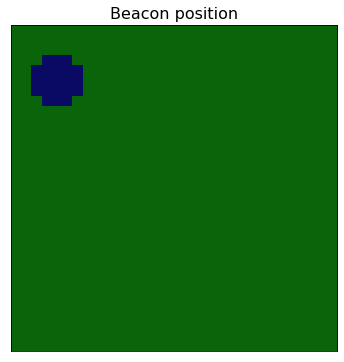

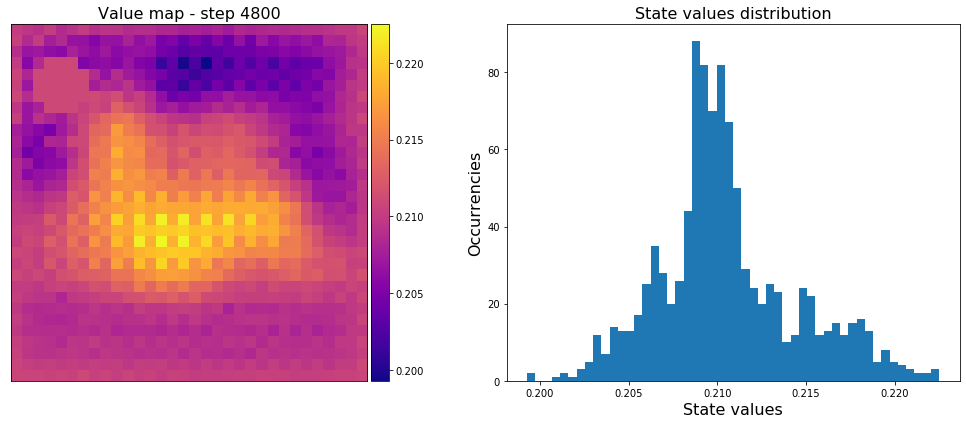

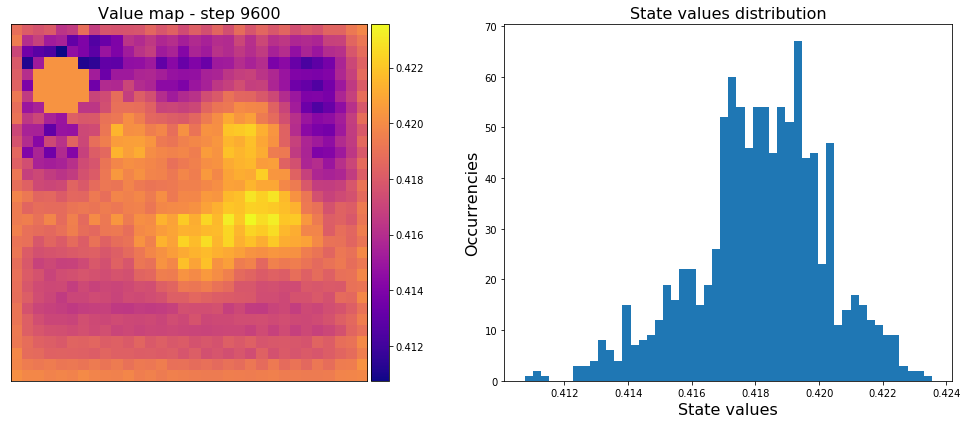

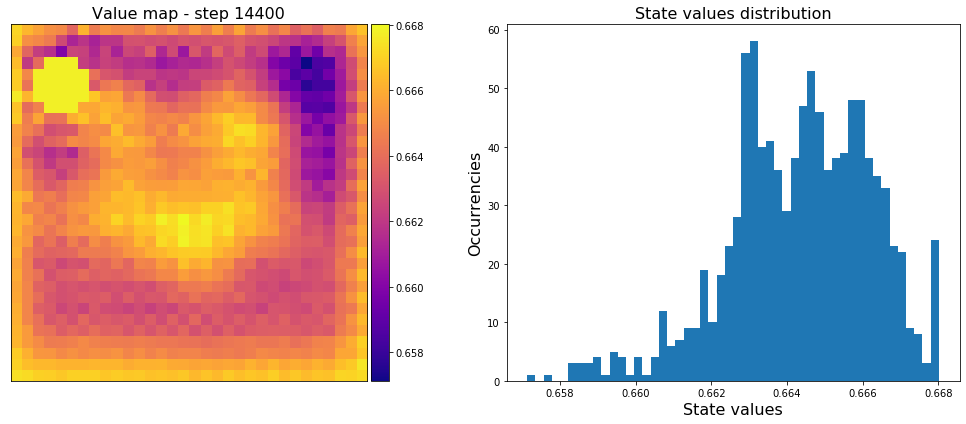

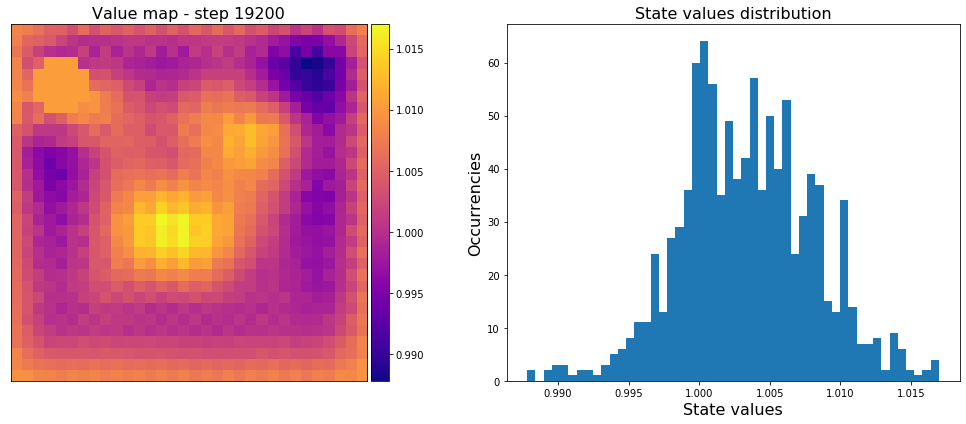

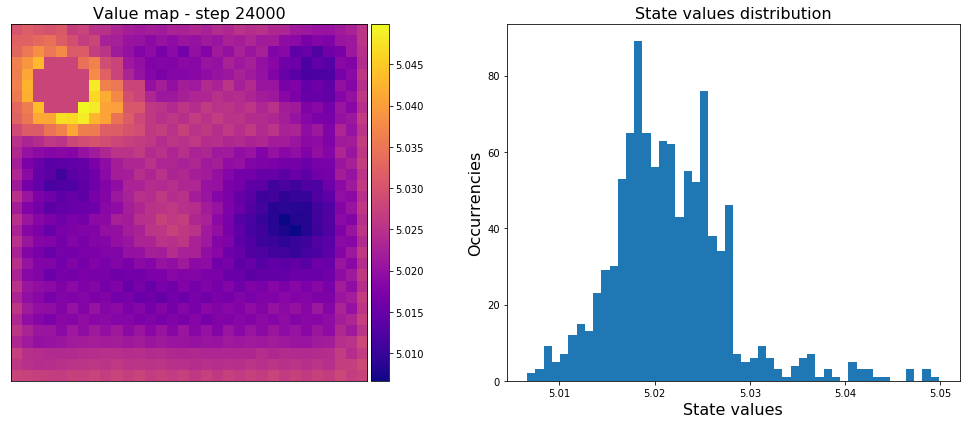

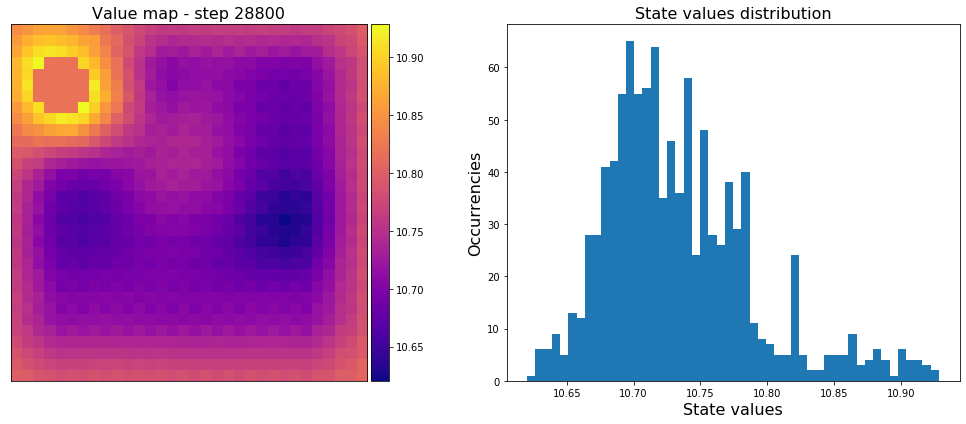

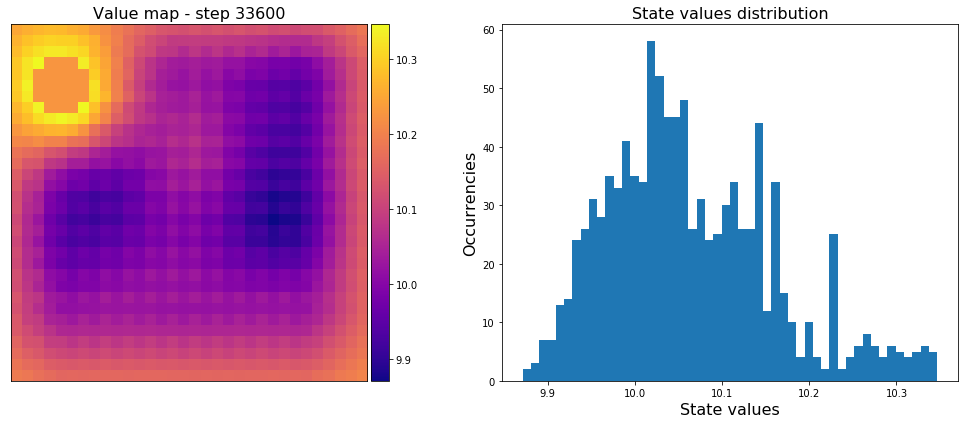

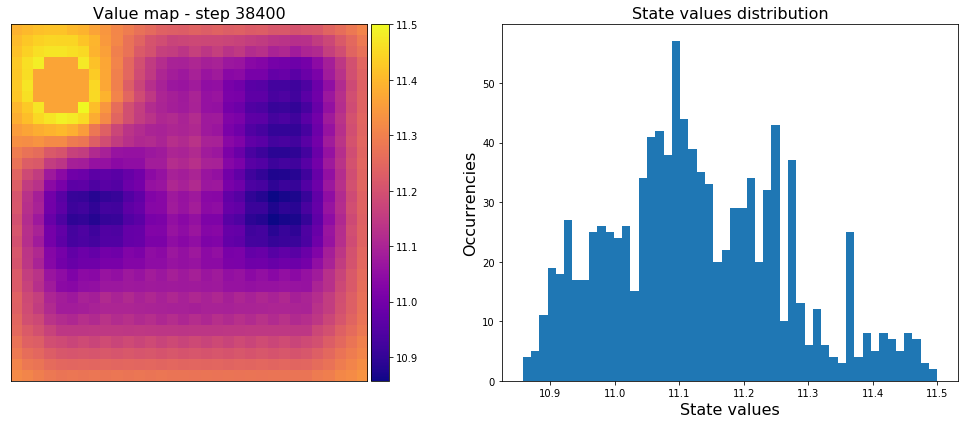

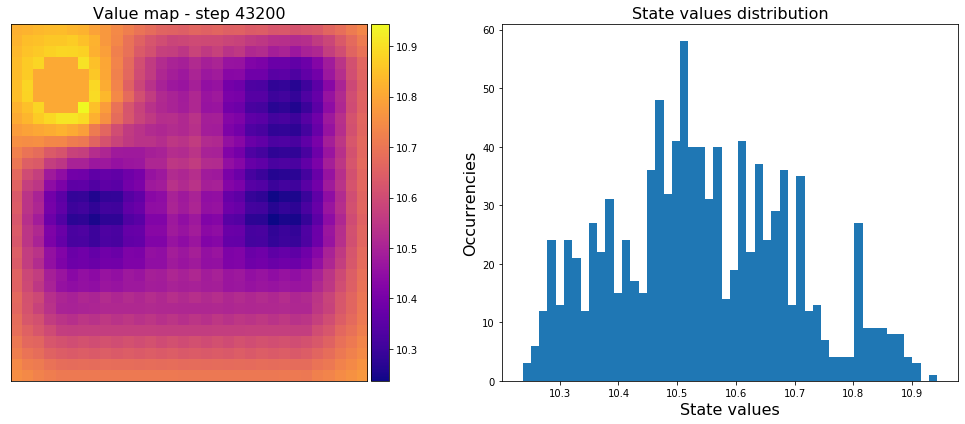

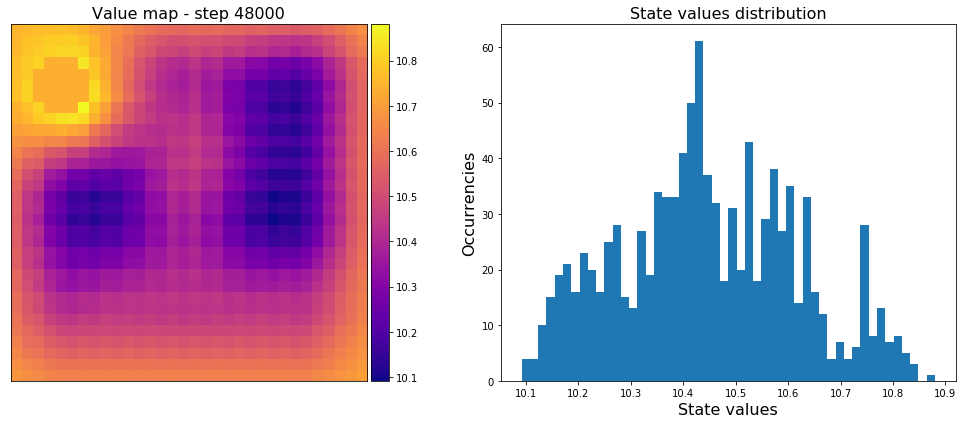

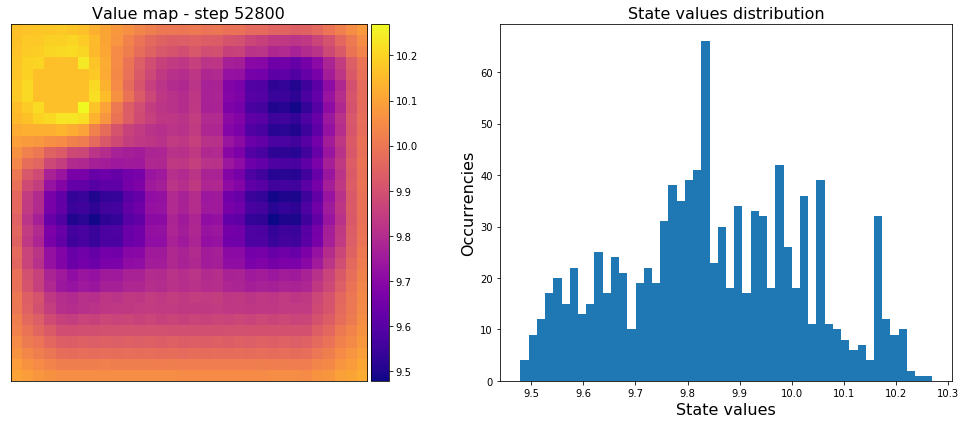

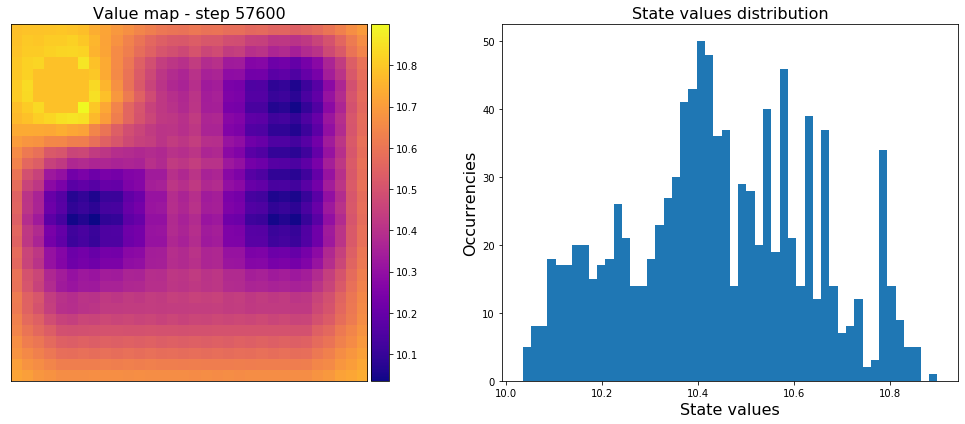

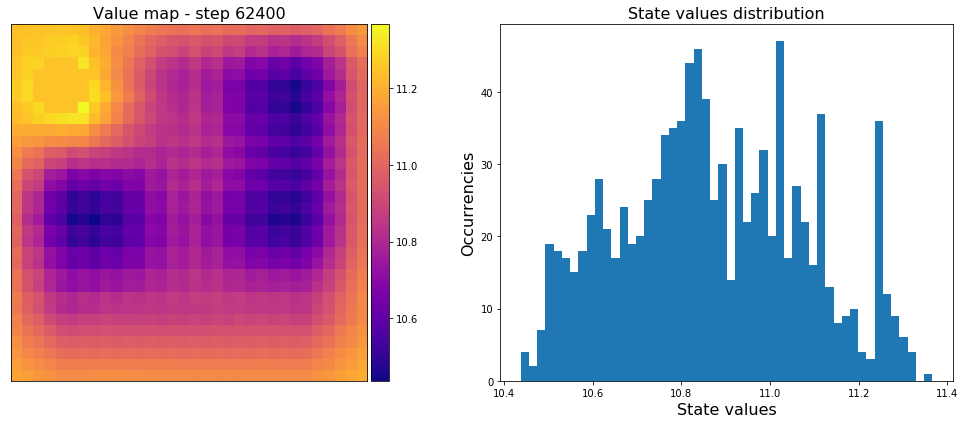

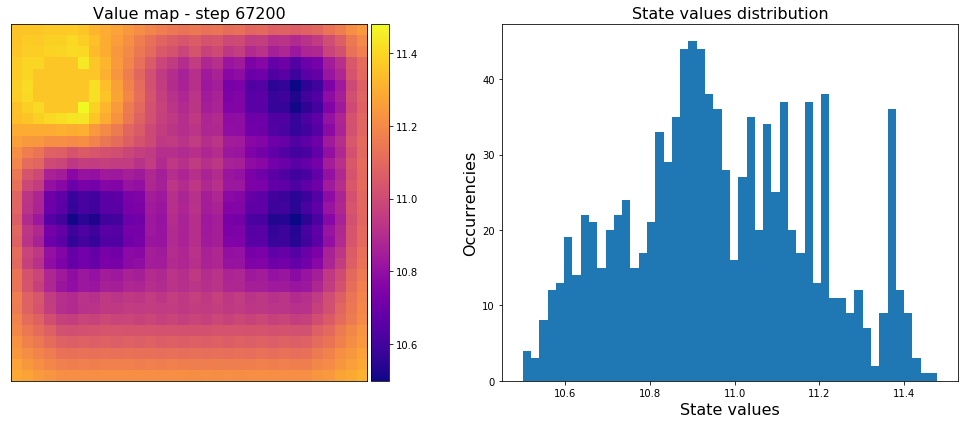

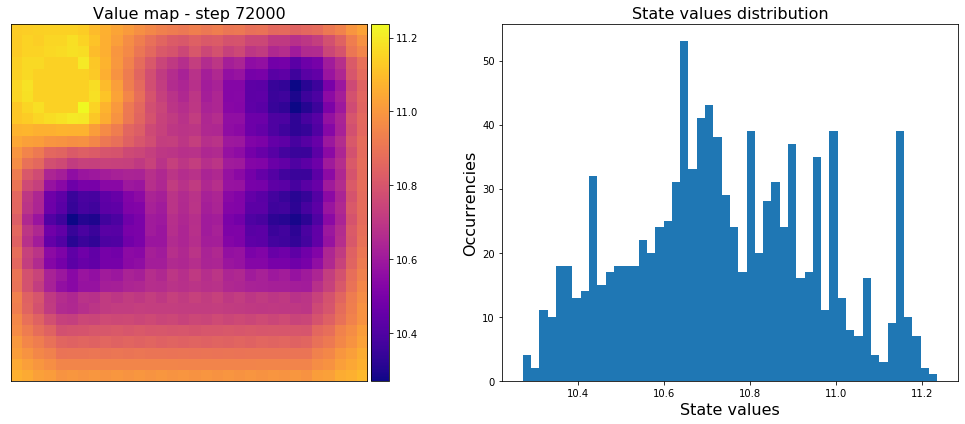

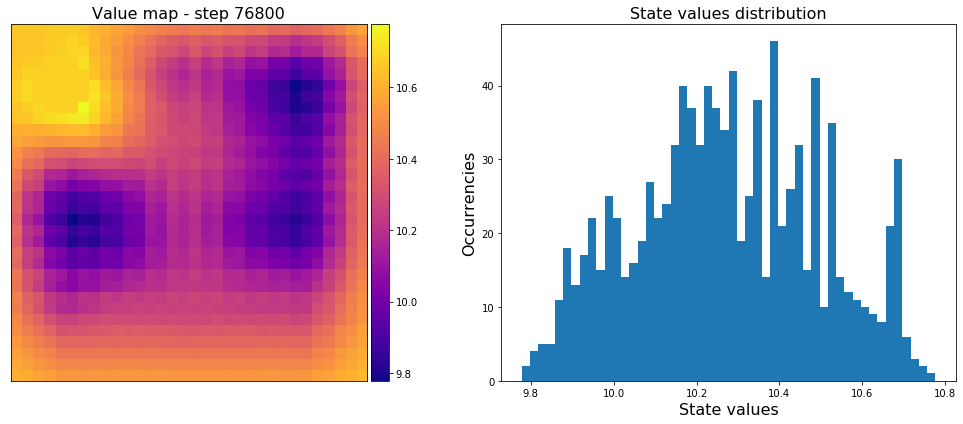

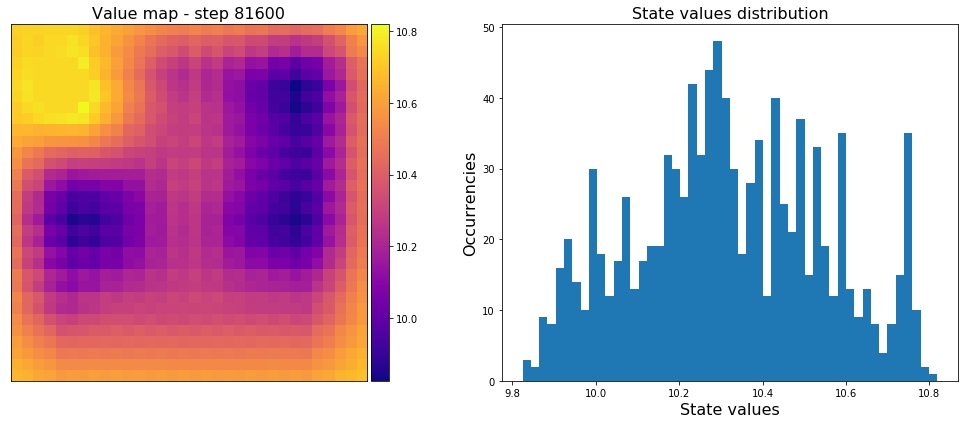

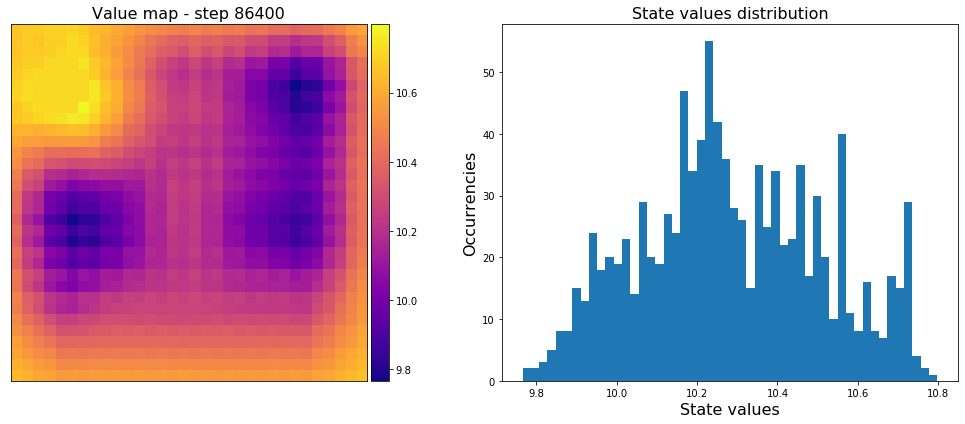

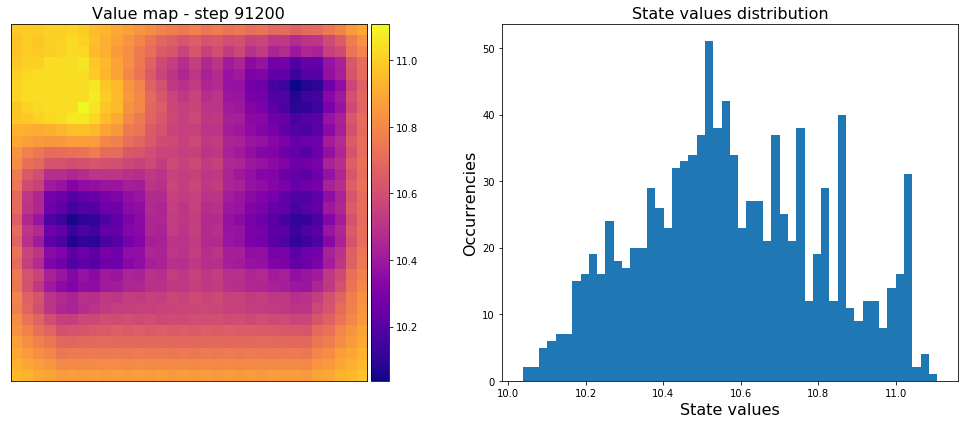

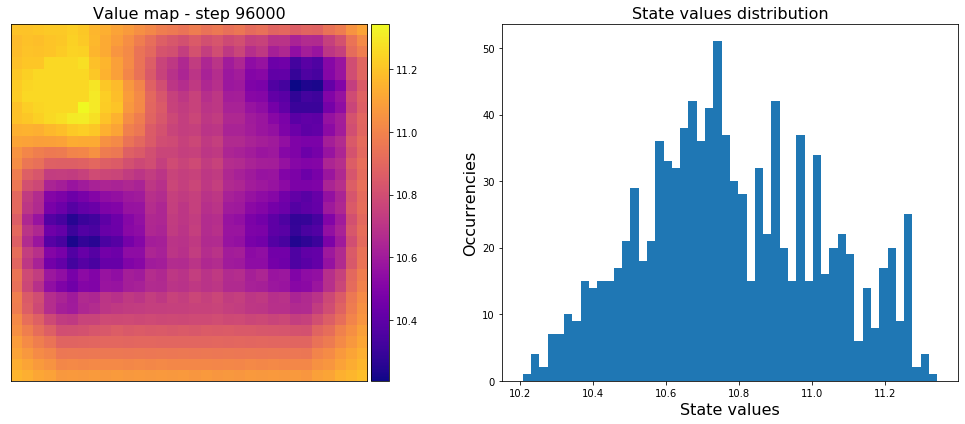

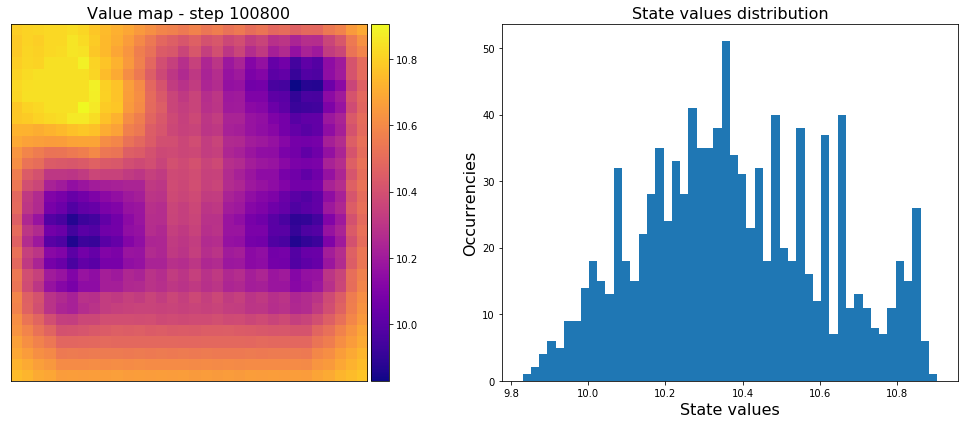

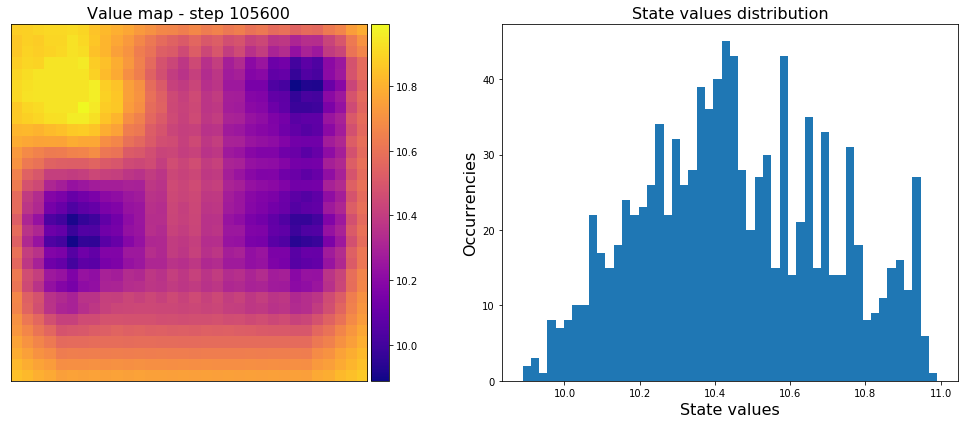

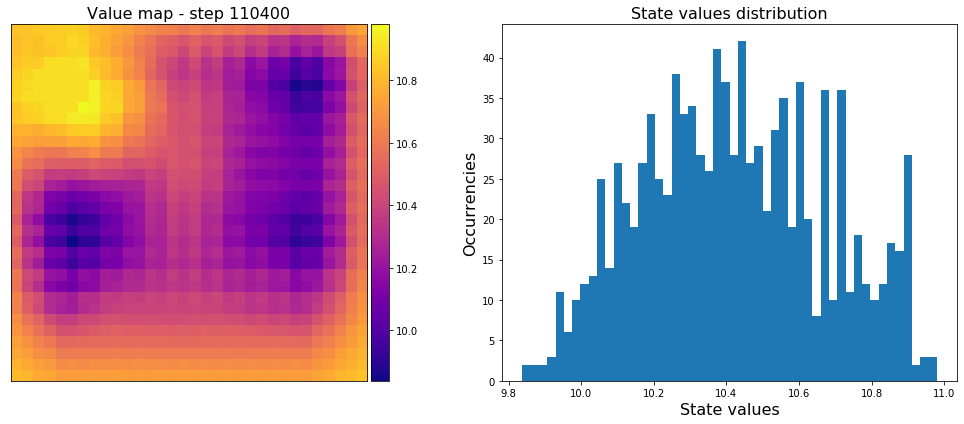

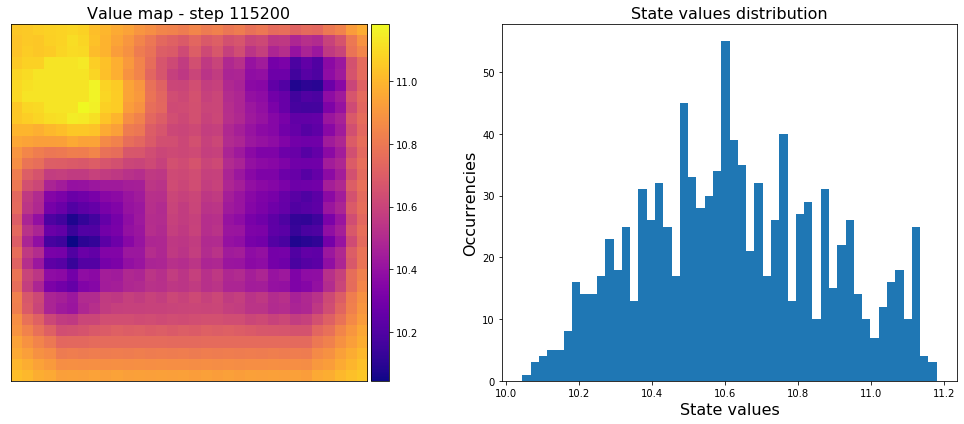

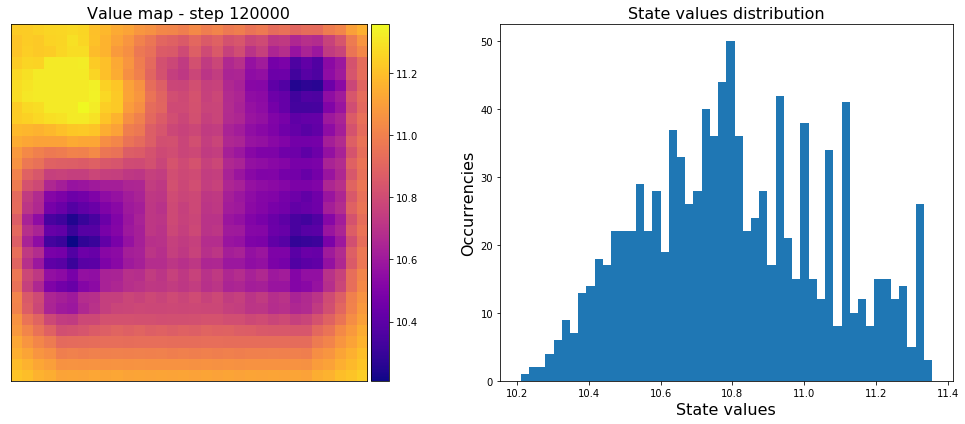

In [6]:
plot_value_maps(agent, PID, init_step, step_jump, n_jumps, beacon_pos = [4,5], n_channels=2, res=32)

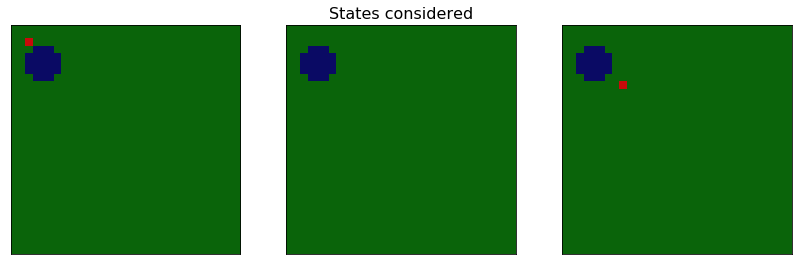

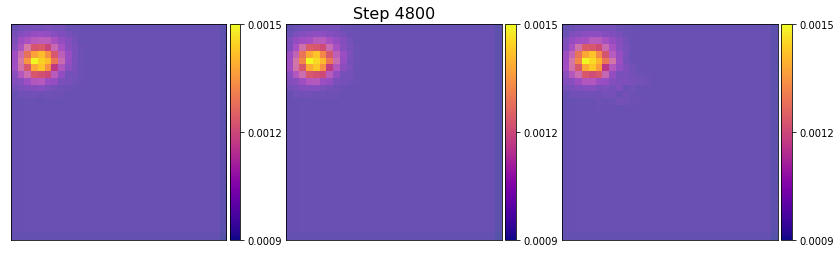

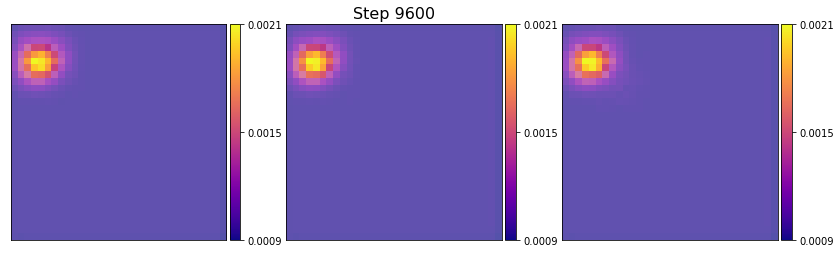

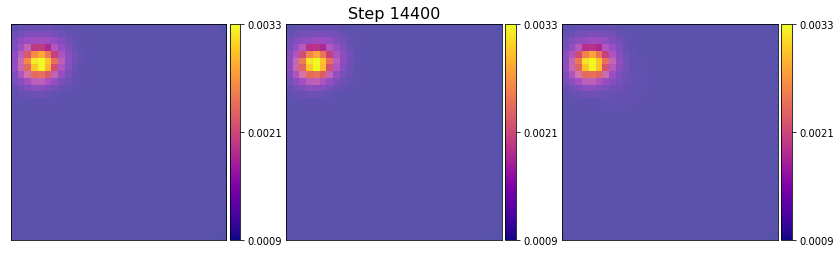

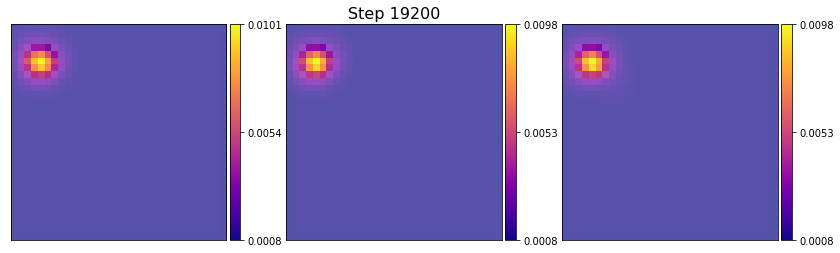

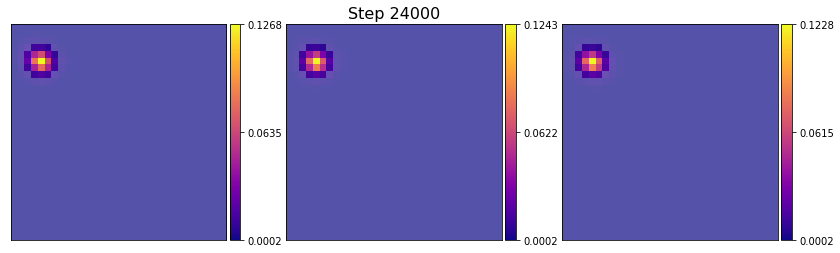

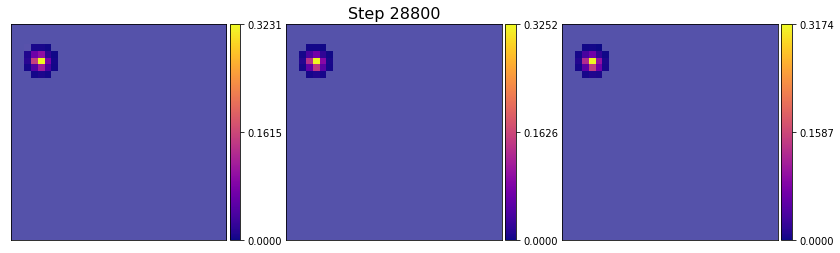

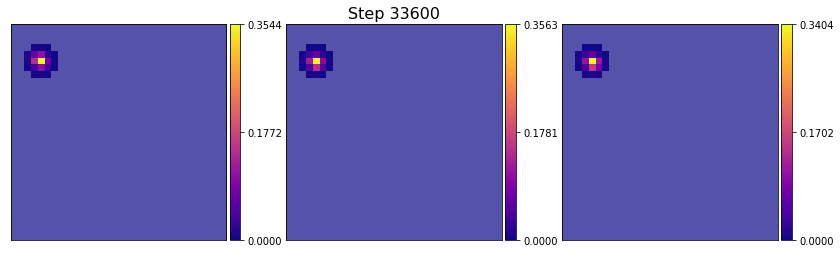

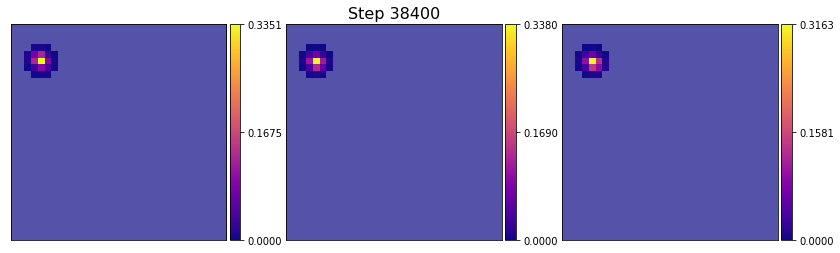

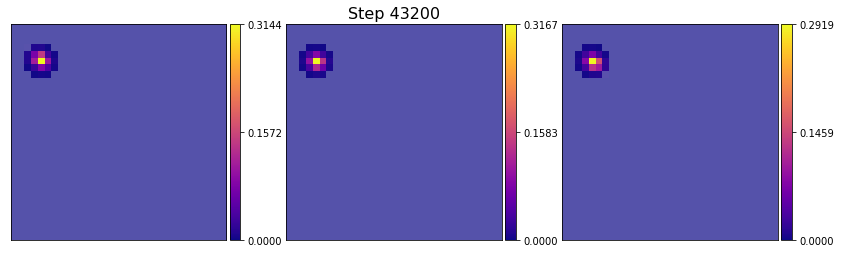

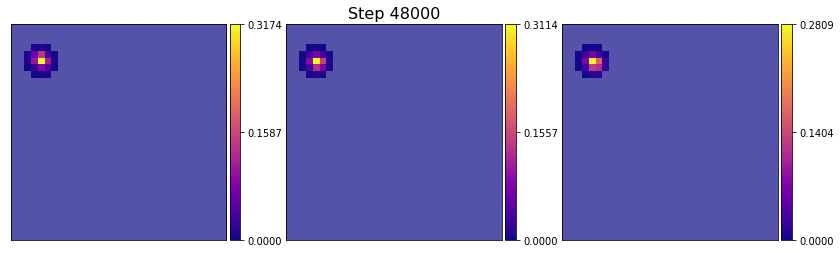

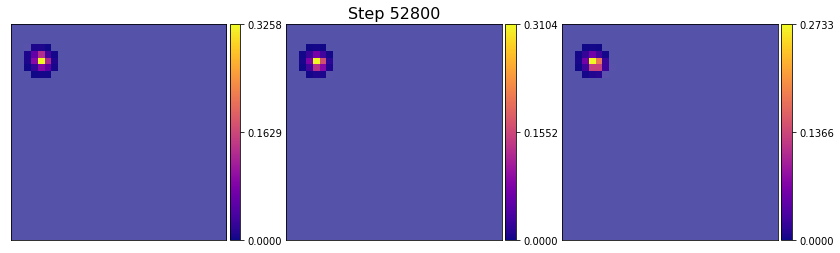

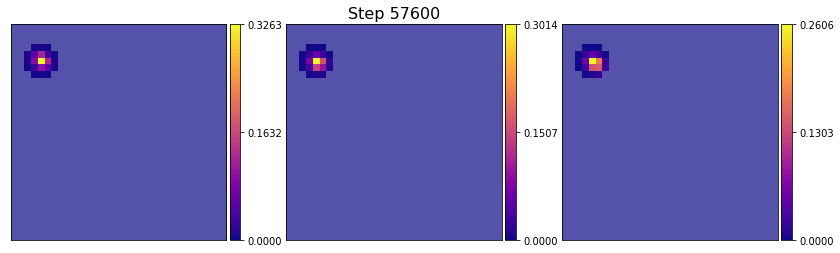

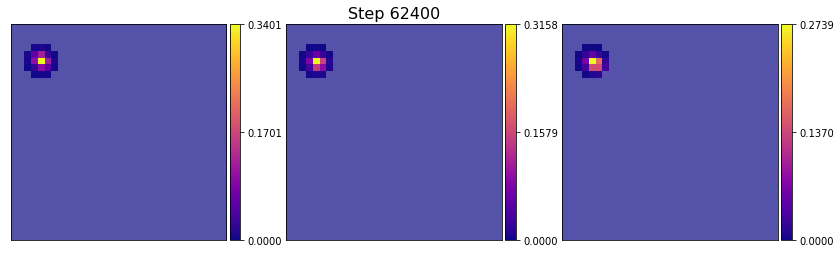

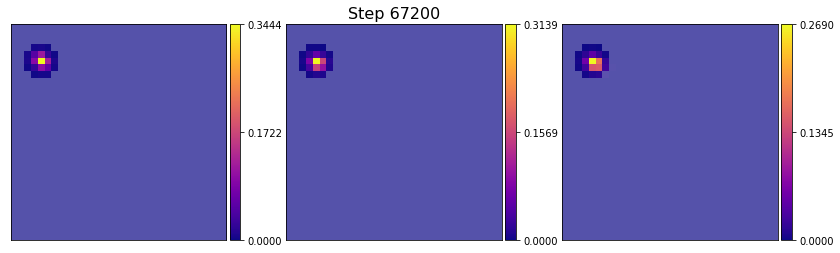

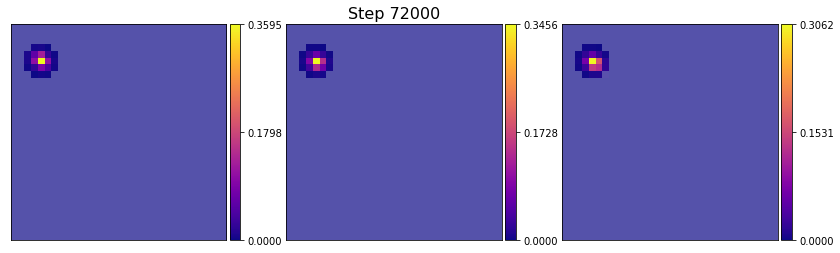

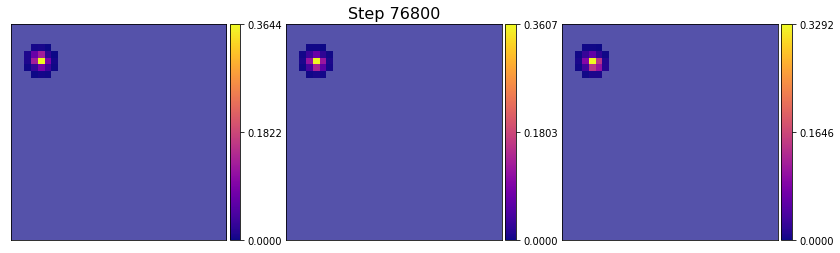

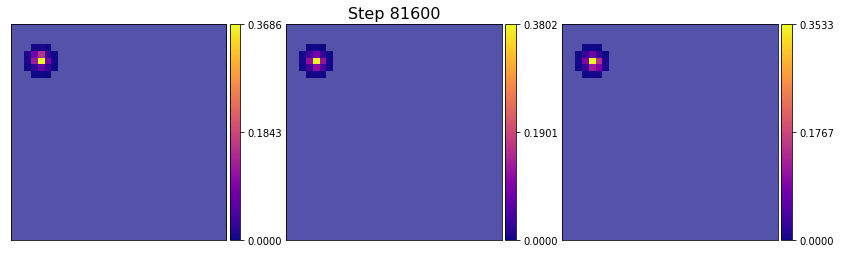

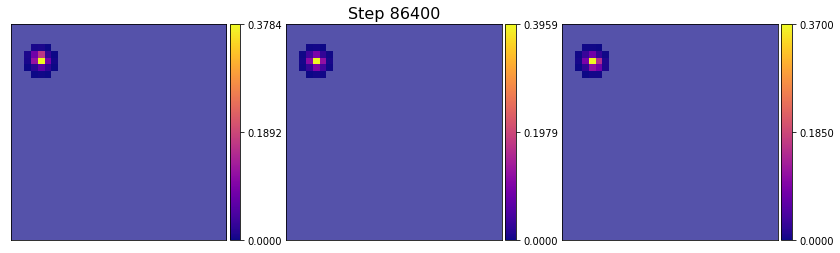

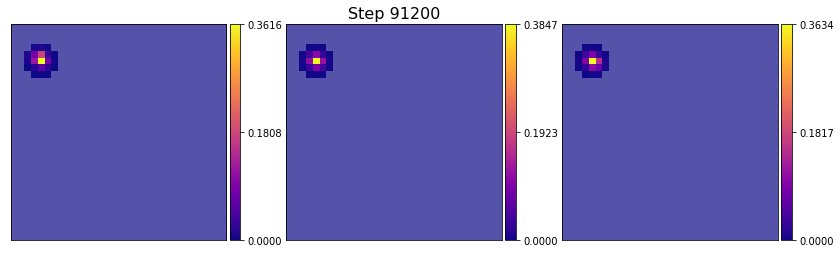

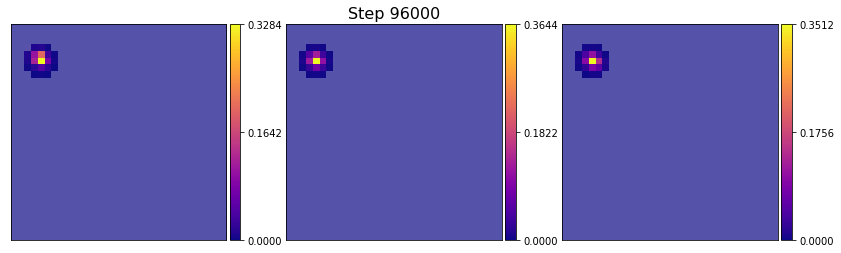

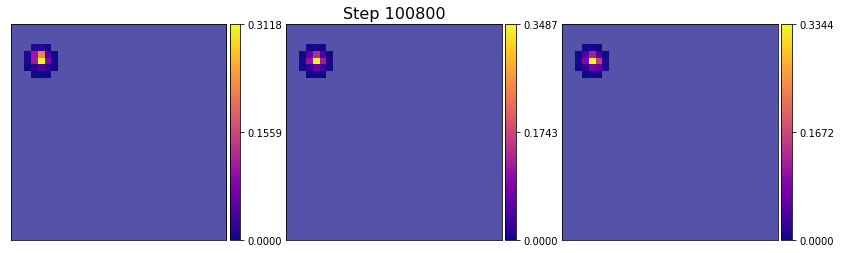

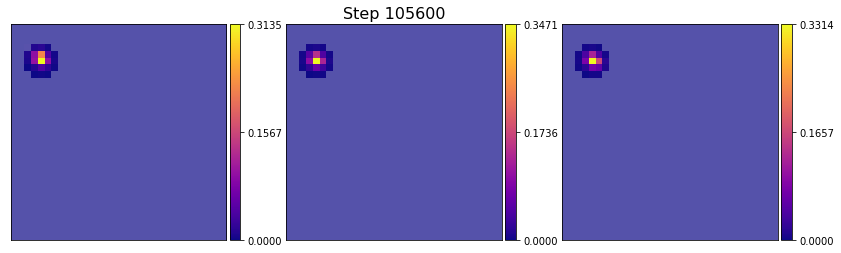

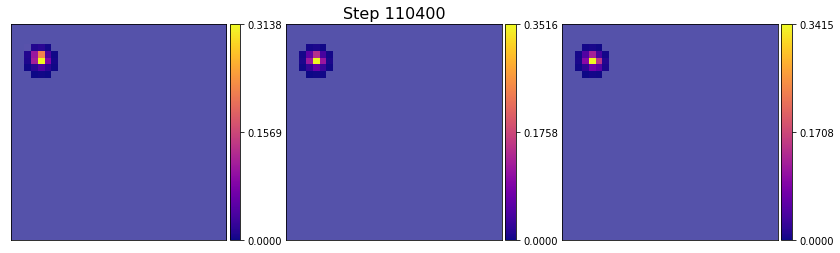

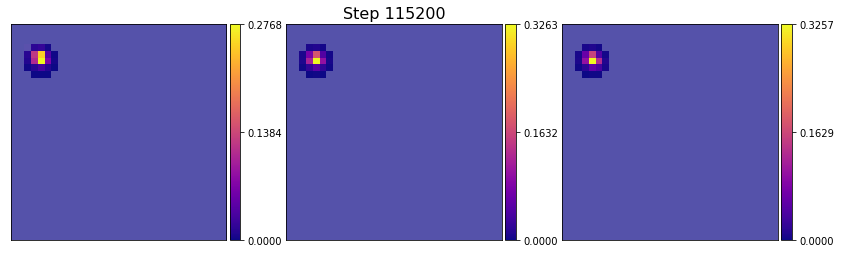

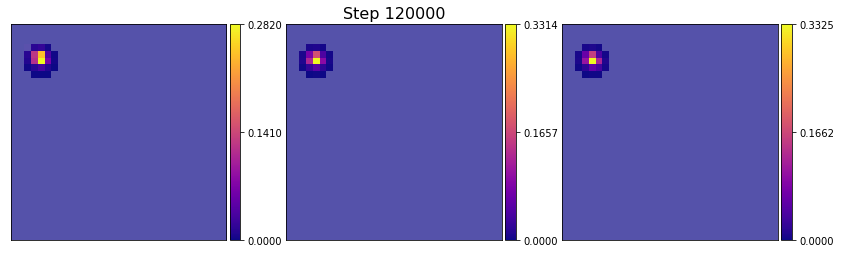

In [7]:
plot_decision_maps(agent, PID, init_step, step_jump, n_jumps, agent_pos_lst=[[2,2],[5,5],[8,8]], 
                       beacon_pos = [4,5], selected=True, n_channels=2, res=32)

# Gradient check in decision map

In [8]:
agent.AC.state_dict().keys()

odict_keys(['spatial_features_net.net.0.weight', 'spatial_features_net.net.0.bias', 'spatial_features_net.net.2.weight', 'spatial_features_net.net.2.bias', 'nonspatial_features_net.conv.0.weight', 'nonspatial_features_net.conv.0.bias', 'nonspatial_features_net.net.0.weight', 'nonspatial_features_net.net.0.bias', 'actor.linear.weight', 'actor.linear.bias', 'critic.net.weight', 'critic.net.bias', 'arguments_networks.queued.net.0.weight', 'arguments_networks.queued.net.0.bias', 'arguments_networks.queued.net.2.weight', 'arguments_networks.queued.net.2.bias', 'arguments_networks.screen.conv.0.weight', 'arguments_networks.screen.conv.0.bias', 'arguments_networks.select_add.net.0.weight', 'arguments_networks.select_add.net.0.bias', 'arguments_networks.select_add.net.2.weight', 'arguments_networks.select_add.net.2.bias'])

In [12]:
init_step = 0
step_jump = 4800
n_jumps = 25
abs_diff = []
for n in range(1,n_jumps):
    
    step_idx = init_step + step_jump*n
    agent.AC.load_state_dict(torch.load("Results/MoveToBeacon/Checkpoints/"+PID+"_"+str(step_idx), map_location='cpu'))
    agent.AC.to(agent.device) 
    
    step_idx = init_step + step_jump*(n+1)
    agent1.AC.load_state_dict(torch.load("Results/MoveToBeacon/Checkpoints/"+PID+"_"+str(step_idx), map_location='cpu'))
    agent1.AC.to(agent.device) 
    
    named_params = agent.AC.named_parameters()
    named_params1 = agent1.AC.named_parameters()
    layers = []
    mean_abs_diff = []
    for n, p in named_params:
        n1, p1 = next(named_params1)
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            d = p - p1
            d = np.abs(d.detach().numpy()).mean()
            mean_abs_diff.append(d)    
    abs_diff.append(mean_abs_diff)

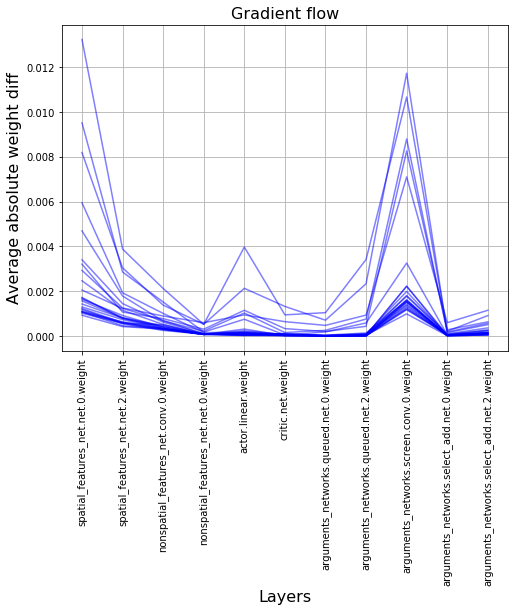

In [13]:
fig = plt.figure(figsize=(8,6))
plt.xlabel("Layers", fontsize=16)
plt.ylabel("Average absolute weight diff", fontsize=16)
plt.title("Gradient flow", fontsize=16)
for i in range(len(abs_diff)):
    plt.plot(np.arange(len(abs_diff[i])), abs_diff[i], c='b', alpha=0.5)
plt.xticks(range(0,len(abs_diff[0]), 1), layers, rotation="vertical")
plt.grid(True)
plt.show()

# Comments

Architecture analysed:
FullyConv (slightly modified), 32x32

- Spatial network: 
    - conv 5x5, padding 2, 16 kernels 
    - ReLU
    - conv 3x3, padding 1, 32 kernels
    - ReLU
- Non-Spatial network: 
    - conv (3x3, stride 2, padding 0, 64 kernels) used to reduce spatial resolution (`new_res=(old_res-kernel_size+1)//stride)`)
    - flatten on pixel + channel dimensions (15x15x64 -> 14400) + linear layer (14400 -> 256) with ReLU

We obtain a 256-dimensional vector, used to compute the policy, value and categorical (non-spatial) parameters.
- Policy net: 256-> n_actions (3)
- Value net: 256 -> 1
- Categorical net: 256 -> 256 -> ReLU -> n_values (usually 2, for boolean flags)

To compute the spatial parameters:
- Conv2d 1x1 kernel from 32 to 1 channels (obtain 1 channel image and sample the pixel after softmax)

**Learning rate**: <br>
- $7\cdot 10^{-4}$

**n-steps used**: 
- Average from 1 to 32 steps

**Entropy regularization**:
- $10^{-3}$ for all probabilities (also those from the parameters, not just the main actions)

**Steps done**: 
- 120k (~50 min)

**Unroll length**:
-  240

**Steps to convergence**:
- 28k

**Problems - SOLVED**:
1. Value map is completely biased, with a baseline of 1 and an asymmetric high-value band on the lower part of the map that is completely wrong
2. Decision map is good in shape, but the values are on the wrong scale (too compressed, so that the difference between good and bad samples is shrinked)
3. The rendering made by the environment is confusing the agent, because when is near the beacon it disappears, so sometimes it learns to select it again, instead of choosing to click on the beacon
4. With the parameters that I chosen the average is ill defined, because I always consider n terms in the average, even if the timestep is less than n steps from the final state; so basically the second to last step is using once the 1-step reward and n-1 times the 2-step reward.
5. I'm still wondering how is working the movement, because the agent motion doesn't seem correlated at all with the point selected in the present or previous state.

**Update**:
1. Value map it's okay for 2 reasons:
    - The lower band is never explored and is an artifact of perspective. Maybe more layers would help in understanding that
    - The value is higher than a single reward because the episode continues even after, so the value is estimating the infinite discounted return that an agent given the current policy and the discount factor would achive.
2. Confirmed the compression of values, looks like a lack of expressional power of the architecture
3. At the same time it is also true that an episode never starts with the agent superimposed on the beacon, so the agent is in the beacon cells only when is already selected and thus the optimal action if the agent is not visible is always to click at the center of the beacon.
4. Still to fix
5. Perspective and action queueing are making everything more difficult to understand

**Obs**:
- double layer in the SpatialParameters network is able to map to 0 all pixels of the map and to non-zero just those that are not visible/accessible.
- This means that somehow there is no signal flowing backwards from the reward; Strangely it started doing like that from the very beginning... 